# OTUS | $p p > Z > e^+ e^-$

This notebooks applies OTUS to our first test case: $Z$ boson decaying into an electron ($e^-$) positron ($e^+$).

Our physical latent-space is the $e^+$, $e^-$ 4-momentum information produced by the program MadGraph and our data-space data is the $e^+$, $e^-$ 4-momentum information produced by the program Delphes.

We arrange this information into 8 dimensional vectors
- Latent space (z): [$p^{\mu}_{e^-}$,$p^{\mu}_{e^+}$]
- Data space (x):   [$p^{\mu}_{e^-}$,$p^{\mu}_{e^+}$]

where $p^{\mu}=[p_x, p_y, p_z, E]$ is the 4-momentum of the given particle.

###### Additional Losses and Constraints:
We impose the following additional losses and constraints in this problem.

First, we impose a constraint on the learned mappings via "anchor losses". This constrains the direction of the electron's 3-momenta when transforming from x-space to z-space and vice versa.

Second, we explicitly enforce the Minkowski metric in the output of the networks. Namely, the networks predict the 3-momenta ($\vec{p}$) of the particles. Energy information is then restored using the Minkowski metric: $E^2 = |\vec{p}|^2 + m^2$.

See the paper for more details: https://arxiv.org/abs/2101.08944.

# Load Required Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

#-- Add utilityFunctions/ to easily use utility .py files --#
import sys
sys.path.append("../../utilityFunctions/")

#-- Determine if using GPU or CPU --#
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'  # Set to '-1' to disable GPU
from configs import device, data_dims

print('Using device:', device)

Using device: cuda


# Meta Parameters

In [2]:
data_directory    = '../../data/'
dataset_name      = 'ppzee'

#-- Set random seeds --#
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

#-- Set data type --#
from configs import float_type
print('Using data type: ', float_type)

Using data type:  float32


# Load Data

In [3]:
from func_utils import get_dataset, standardize
from torch.utils.data import DataLoader


#-- Get training and validation dataset --#
dataset = get_dataset(dataset_name, data_dir=data_directory) 
z_data, x_data = dataset['z_data'], dataset['x_data']

MET = False # Exclude Missing Transverse Energy (MET) from x-space data
if MET == False:
    x_data = x_data[:, :-4]
print("Data total shapes: ",z_data.shape, x_data.shape)

x_dim = int(x_data.shape[1])
z_dim = int(z_data.shape[1])

#-- Split into training and validation sets --#
train_size = 291699
val_size = 40000  # Validation set used to evaluate/tune models

x_train = x_data[:train_size, :]
x_val = x_data[train_size:train_size+val_size, :]

z_train = z_data[:train_size, :]
z_val = z_data[train_size:train_size+val_size, :]

#-- Convert data to proper type --#
x_train, x_val, z_train, z_val = list(map(lambda x: x.astype(float_type), [x_train, x_val, z_train, z_val]))

#-- Obtain mean and std information --#
# This is needed to standardize/unstandardize data
x_train_mean, x_train_std = np.mean(x_train, axis=0), np.std(x_train, axis=0) 
z_train_mean, z_train_std = np.mean(z_train, axis=0), np.std(z_train, axis=0)

#-- Set evaluation parameters --#
eval_batch_size = 20000  # Always use high batch size on validation set to accurately assess performance
eval_loaders = DataLoader(dataset=x_val, batch_size=eval_batch_size, shuffle=True), \
               DataLoader(dataset=z_val, batch_size=eval_batch_size, shuffle=True)

print("z_train shape, x_train shape: ", z_train.shape, x_train.shape)
print("z_val   shape, x_val   shape: ", z_val.shape, x_val.shape)


Data total shapes:  (331699, 8) (331699, 8)
z_train shape, x_train shape:  (291699, 8) (291699, 8)
z_val   shape, x_val   shape:  (40000, 8) (40000, 8)


### Define target invariant masses (for both training and validation data)

Invariant mass relation: $m^2 = E^2 - |\vec{p}|^2$ 

In [4]:
#-- Look at m2 values empirically --#
print('X space')
tmp = x_data
for i in range(int(tmp.shape[1] / 4)):
    p = tmp[:, 4*i : 4*i+3]  # 3-momentum, (px, py, pz)
    E = tmp[:, 4*i+3]        # Energy
    m2 = (E**2 - (p ** 2).sum(axis=-1))
    print('particle %d mass^2 = %g +- %g' %(i, m2.mean(), m2.std()))

print('Z space')
tmp = z_data
for i in range(int(tmp.shape[1] / 4)):
    p = tmp[:, 4*i : 4*i+3]  # 3-momentum, (px, py, pz)
    E = tmp[:, 4*i+3]        # Energy
    m2 = (E**2 - (p ** 2).sum(axis=-1))
    print('particle %d mass^2 = %g +- %g' %(i, m2.mean(), m2.std()))

X space
particle 0 mass^2 = 2.01129e-15 +- 3.62862e-12
particle 1 mass^2 = -1.17544e-14 +- 3.50494e-12
Z space
particle 0 mass^2 = -1.34586e-09 +- 6.17582e-07
particle 1 mass^2 = -1.48398e-10 +- 5.71702e-07


Note that the fact that these values are slightly negative is a purely numerical effect. Thus we instead define them to the value they should have, namely 0. (massless).

In [5]:
#-- Define target invariant masses --#
x_inv_masses = np.zeros(2)
z_inv_masses = np.zeros(2)

# Train

## Import Training Specific Libraries and Functions

In [6]:
import torch
from torch import optim
from ppzee_utils import train_and_val

## Define Meta Network Parameters

In [7]:
cond_noise = True  # Whether to use conditional Gaussian (instead of standard normal) for noise in enc/dec
if cond_noise:
    from models import CondNoiseAutoencoder
    Autoencoder = CondNoiseAutoencoder  # Define alias 
else:
    from models import Autoencoder

## Define Model and Hyperparameters

###### Latent loss function: 
Finite sample approximation of Sliced Wasserstein Distance (SWD) between $p(z)$ and $p_E(z) = \int_x p(x) p_E(z|x)$
- $L_{latent}(Z, \tilde{Z}) = \frac{1}{L * M} \sum_{l=1}^{L} \sum_{m=1}^{M} c((\theta_l \cdot z_m)_{sorted}, (\theta_l \cdot \tilde{z}_m)_{sorted})$ 

where $c(\cdot, \cdot) = |\cdot - \cdot|^2$

###### Data loss function: 
- $L_{data}(X, \tilde{X}) = \frac{1}{M} \sum_{m=1}^M c(x_m,  \tilde{x}_m)$

where $c(\cdot, \cdot) = |\cdot - \cdot|^2$

###### Additional loss functions: 
Encoder and decoder anchor losses
- $L_{A}(X, \tilde{Z}) = \frac{1}{M} \sum_{m=1}^M c_A(x_m, \tilde{z}_m)$
- $L_{A}(Z, \tilde{X}') = \frac{1}{M} \sum_{m=1}^M c_A(z_m, \tilde{x}'_m)$

see the paper for additional details about $c_A$.

###### Full loss function:
- $L_{tot} = \beta L_{data}(X, \tilde{X}) + \lambda L_{latent}(Z, \tilde{Z}) + \nu_e L_{A}(X, \tilde{Z}) + \nu_d L_{A}(Z, \tilde{X}')$

###### Core Hyperparameters
The hyperparameter definitions are as follows:
- num_hidden_layers:    The number of hidden layers in both the encoder and decoder networks
- dim_per_hidden_layer: The dimensions per hidden layer in both the encoder and decoder networks
- lr: The learning rate of the networks
- lamb: The $\lambda$ coefficient in front of the latent loss term
- num_slices: Number of random projections used for computing SWD
- epochs: The number of epochs used during training

Hyperparameters for other losses that were tried, but use during main training is currently discouraged:
- tau: Coefficient in front of the alternate data-space loss ("alt_x_loss"), which is the SWD between $p(x)$ and $p_D(x):=\int_z p(z) p_D(x|z)$
- rho: Coefficient in front of an additional decoder constraint loss (based on soft-penalty approach to learning hard thresholds/ttbar_constraints)

###### Joint Training Hyperparameters

- beta: Coefficient in front of data loss, $L_{data}$     
- nu_e: Coefficient in front of the encoder "anchor loss" 
- nu_d: Coefficient in front of the decoder "anchor loss" 

In [8]:
config = {
    'num_hidden_layers': 1,
    'dim_per_hidden_layer': 128,
    'lr': 0.001,
    'lamb': 1.,
    'tau': 0,  
    'rho': 0,  
    'num_slices': 1000,
    'epochs': 80,
}

joint_step_config = {
    'beta': 1.,  
    'lamb': 1.,
    'nu_e': 1e-5,  
    'nu_d': 1e-5,
}

encoder_step_config = {
    'beta': 0.,
    'lamb': 1.,
#     'nu_e': 1e-2,
    'nu_e': 0.,
    'nu_d': 0.,
}

num_hidden_layers, dim_per_hidden_layer = config['num_hidden_layers'], config['dim_per_hidden_layer']
hidden_layer_dims = num_hidden_layers * [dim_per_hidden_layer]

activation = torch.nn.ReLU
sigma_fun = 'softplus'  # Default is 'exp'
model = Autoencoder(x_dim=x_dim, z_dim=z_dim, hidden_layer_dims=hidden_layer_dims, raw_io=True,
                    x_stats=np.stack([x_train_mean, x_train_std]), z_stats=np.stack([z_train_mean, z_train_std]),
                    x_inv_masses=x_inv_masses, z_inv_masses=z_inv_masses,
                    stoch_enc=True, stoch_dec=True, activation=activation, sigma_fun=sigma_fun)

In [9]:
# Print model 
model

CondNoiseAutoencoder(
  (encoder): CondNoiseMLP(
    (sigma_fun): Softplus(beta=1, threshold=20)
    (output_nn): Sequential(
      (0): Linear(in_features=14, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=6, bias=True)
    )
    (cond_noise_nn): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=12, bias=True)
    )
  )
  (decoder): CondNoiseMLP(
    (sigma_fun): Softplus(beta=1, threshold=20)
    (output_nn): Sequential(
      (0): Linear(in_features=14, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=6, bias=True)
    )
    (cond_noise_nn): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=12, bias=True)
    )
  )
)

In [10]:
train_batch_size = 20000
train_loaders = DataLoader(dataset=x_train, batch_size=train_batch_size, shuffle=True), \
                DataLoader(dataset=z_train, batch_size=train_batch_size, shuffle=True)

## Training Stage 1

Perform a joint training strategy (encoder and decoder simultaneously) with a high anchor penalty. This strategy of joint training is the vanilla SWAE approach.

In [11]:
%%time


#-- Set high anchor loss penalties --#
joint_step_config['nu_e'] = joint_step_config['nu_d'] = 50
config.update(**joint_step_config)

#-- Set number of stage 1 epochs --#
config['epochs'] = 80

#-- Set optimizer --#
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

#-- Train --#
history = None
eval_losses, history = train_and_val(model, train_loaders, eval_loaders, config, optimizer, verbose=True, 
                                      prev_hist=history, log_freq=20, lr_decay=False)

{'num_hidden_layers': 1, 'dim_per_hidden_layer': 128, 'lr': 0.001, 'lamb': 1.0, 'tau': 0, 'rho': 0, 'num_slices': 1000, 'epochs': 80, 'beta': 1.0, 'nu_e': 50, 'nu_d': 50}
epoch:	0
train -- loss:3866.56, x_loss:3026.07, z_loss:752.567, alt_x_loss:0, x_constraint_loss:0, anchor_loss:1.75828
eval -- loss:2549.91, x_loss:2952.48, z_loss:652.506, alt_x_loss:1897.41, anchor_loss:1.7768
epoch:	20
train -- loss:86.005, x_loss:24.3948, z_loss:27.8, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0.676204
eval -- loss:213.952, x_loss:24.0432, z_loss:20.9607, alt_x_loss:192.992, anchor_loss:0.836525
epoch:	40
train -- loss:32.5301, x_loss:15.862, z_loss:11.6214, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0.100934
eval -- loss:88.6372, x_loss:15.3025, z_loss:6.93504, alt_x_loss:81.7022, anchor_loss:0.14543
epoch:	60
train -- loss:19.2811, x_loss:11.2412, z_loss:5.82776, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0.0442424
eval -- loss:71.5851, x_loss:10.7484, z_loss:5.31696, alt_x_loss:66.2

## Training Stage 2

Now turn off anchor loss penalty to focus on other losses. Fortunately, the anchor losses still decrease by themselves.

In [12]:
#-- Turn off anchor loss penalties --#
joint_step_config['nu_e'] = joint_step_config['nu_d'] = 0
config.update(**joint_step_config)

#-- Set number of stage 2 epochs --#
config['epochs'] = 200

#-- Set optimizer --#
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

#-- Train --#
history = None
eval_losses, history = train_and_val(model, train_loaders, eval_loaders, config, optimizer, verbose=True, 
                                      prev_hist=history, log_freq=50, lr_decay=False)

{'num_hidden_layers': 1, 'dim_per_hidden_layer': 128, 'lr': 0.001, 'lamb': 1.0, 'tau': 0, 'rho': 0, 'num_slices': 1000, 'epochs': 200, 'beta': 1.0, 'nu_e': 0, 'nu_d': 0}
epoch:	0
train -- loss:47.1706, x_loss:39.11, z_loss:8.06061, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:78.4696, x_loss:39.8688, z_loss:4.42967, alt_x_loss:74.0399, anchor_loss:0.0406574
epoch:	50
train -- loss:9.78589, x_loss:5.32533, z_loss:4.46056, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:68.8336, x_loss:5.30711, z_loss:3.04267, alt_x_loss:65.7909, anchor_loss:0.064696
epoch:	100
train -- loss:7.75241, x_loss:2.11447, z_loss:5.63794, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:59.6181, x_loss:2.00822, z_loss:3.07576, alt_x_loss:56.5423, anchor_loss:0.0634124
epoch:	150
train -- loss:12.7305, x_loss:1.1212, z_loss:11.6093, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:45.7386, x_loss:1.09928, z_loss:3.45286, alt_x_loss:42.2858, anchor_loss:0.0

Continue with more iterations of the above.

In [13]:
#-- Turn off anchor loss penalties --#
joint_step_config['nu_e'] = joint_step_config['nu_d'] = 0
config.update(**joint_step_config)

#-- Set number of additional stage 2 epochs --#
config['epochs'] = 200

#-- Set optimizer --#
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

#-- Train --#
history = None
eval_losses, history = train_and_val(model, train_loaders, eval_loaders, config, optimizer, verbose=True, 
                                      prev_hist=history, log_freq=50, lr_decay=True)

{'num_hidden_layers': 1, 'dim_per_hidden_layer': 128, 'lr': 0.001, 'lamb': 1.0, 'tau': 0, 'rho': 0, 'num_slices': 1000, 'epochs': 200, 'beta': 1.0, 'nu_e': 0, 'nu_d': 0}
epoch:	0
train -- loss:15.0398, x_loss:5.19652, z_loss:9.84328, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:34.0173, x_loss:4.01593, z_loss:2.26386, alt_x_loss:31.7534, anchor_loss:0.0428373
epoch:	50
train -- loss:5.96857, x_loss:0.601654, z_loss:5.36691, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:23.3561, x_loss:0.676881, z_loss:1.93652, alt_x_loss:21.4196, anchor_loss:0.0402232
epoch:	100
train -- loss:10.7371, x_loss:0.545332, z_loss:10.1917, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:23.8519, x_loss:0.555465, z_loss:2.06549, alt_x_loss:21.7864, anchor_loss:0.0390614
epoch:	150
train -- loss:5.90366, x_loss:0.774115, z_loss:5.12954, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:20.0891, x_loss:0.56568, z_loss:1.448, alt_x_loss:18.6411, anchor_l

This is looking better, can run below evaluation cells to inspect before more training.

## Training Stage 3

Implement strategy with no anchor loss and more joint epochs.

In [14]:
#-- Turn off anchor loss penalties --#
joint_step_config['nu_e'] = joint_step_config['nu_d'] = 0
config.update(**joint_step_config)

#-- Set number of stage 3 epochs --#
config['epochs'] = 400

#-- Set optimizer --#
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

#-- Train --#
history = None
eval_losses, history = train_and_val(model, train_loaders, eval_loaders, config, optimizer, verbose=True, 
                                      prev_hist=history, log_freq=50, lr_decay=False)

{'num_hidden_layers': 1, 'dim_per_hidden_layer': 128, 'lr': 0.001, 'lamb': 1.0, 'tau': 0, 'rho': 0, 'num_slices': 1000, 'epochs': 400, 'beta': 1.0, 'nu_e': 0, 'nu_d': 0}
epoch:	0
train -- loss:12.3902, x_loss:8.87852, z_loss:3.51168, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:21.899, x_loss:5.04633, z_loss:1.78533, alt_x_loss:20.1137, anchor_loss:0.0370726
epoch:	50
train -- loss:5.85545, x_loss:1.13237, z_loss:4.72308, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:14.5128, x_loss:0.650498, z_loss:2.00907, alt_x_loss:12.5038, anchor_loss:0.0330827
epoch:	100
train -- loss:8.16022, x_loss:1.11903, z_loss:7.04119, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:11.7239, x_loss:1.34505, z_loss:1.60809, alt_x_loss:10.1158, anchor_loss:0.0298986
epoch:	150
train -- loss:8.39179, x_loss:1.0266, z_loss:7.36519, alt_x_loss:0, x_constraint_loss:0, anchor_loss:0
eval -- loss:7.6057, x_loss:0.696118, z_loss:1.64027, alt_x_loss:5.96543, anchor_loss:

## Plot Loss History

History dictionary:

history = {key: [] for key in ('epoch', 'train_loss', 'train_x_loss', 'train_z_loss', 'train_alt_x_loss', 'eval_loss')}

- train_loss: Total training loss 
- train_x_loss: Data space (x-space) training loss
- train_z_loss: Latent space (z-space) training loss
- train_alt_x_loss: Alternate data space loss; use is discouraged

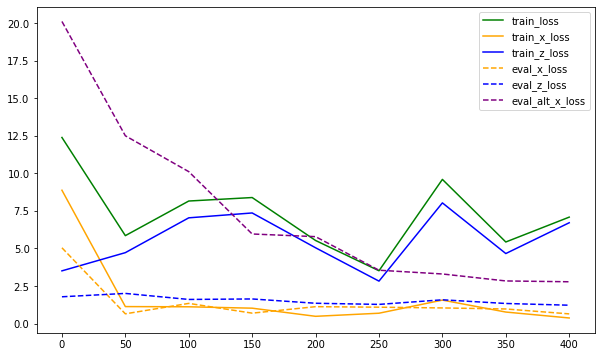

In [15]:
fig = plt.figure(figsize=(10,6))

#-- Plot training loss history --#
plt.plot(history['epoch'], history['train_loss'], color='green', label='train_loss')
plt.plot(history['epoch'], history['train_x_loss'], color='orange', label='train_x_loss')
plt.plot(history['epoch'], history['train_z_loss'], color='blue', label='train_z_loss')
# plt.plot(history['epoch'], history['train_alt_x_loss'], color='purple', label='train_alt_x_loss')

#-- Plot evaluation loss history --#
# plt.plot(history['epoch'], history['eval_loss'], color='green', linestyle='--', label='eval_loss')
plt.plot(history['epoch'], history['eval_x_loss'], color='orange', linestyle='--', label='eval_x_loss')
plt.plot(history['epoch'], history['eval_z_loss'], color='blue', linestyle='--', label='eval_z_loss')
plt.plot(history['epoch'], history['eval_alt_x_loss'], color='purple', linestyle='--', label='eval_alt_x_loss')

plt.legend(loc='best')

# Show Results

Now that we've trained our model, it's time to inspect the results. Note that the following plots are meant to be illustrative and do not represent an exhaustive survey. 

In [16]:
# Import relevant plotting functions
from plot_utils import plotFunction

## Get Results

In [17]:
model.to('cpu')
model.encoder.output_stats.to('cpu')
model.decoder.output_stats.to('cpu')

all_arrs = {'train': {}, 'val': {}}  # This will store all numpy arrays of interest
all_arrs['train']['x'] = x_train
all_arrs['train']['z'] = z_train
all_arrs['val']['x']   = x_val
all_arrs['val']['z']   = z_val

for data_key in 'train', 'val':
    arrs = all_arrs[data_key]
    arrs['z_decoded']       = model.decode(torch.from_numpy(arrs['z'])) # p_D(x) = \int_z p(z) p_D(x|z)  "x_pred_truth"
    arrs['x_encoded']       = model.encode(torch.from_numpy(arrs['x'])) # p_E(z) = \int_x p(x) p_E(z|x)  "z_pred"
    arrs['x_reconstructed'] = model.decode(arrs['x_encoded'])     # p_D(y) = \int_x \int_z p(x) p_E(z|x) p_D(y|z) "x_pred"
    
    # Feed the same z input to the decoder multiple times and study the stochastic of the output
    num_repeats = 100
    num_diff_zs = 100
    arrs['z_rep']         = np.array([np.repeat(arrs['z'][i:i+1], num_repeats, axis=0) for i in range(num_diff_zs)]) # "z_fixed"
    z_rep_tensor          = torch.from_numpy(arrs['z_rep'])                                                          # tmp
    arrs['z_decoded_rep'] = np.array([model.decode(z_rep_tensor[i]).detach().numpy() for i in range(num_diff_zs)])   # "x_pred_truth_fixed"
    arrs['x_rep']         = np.array([np.repeat(arrs['x'][i:i+1], num_repeats, axis=0) for i in range(num_diff_zs)]) # "x_fixed"

    # Convert all results to numpy arrays
    for (field, arr) in arrs.items():
        if isinstance(arr, torch.Tensor):
            arrs[field] = arr.detach().numpy()

## Inspect Principal Axes Matching On Validation Data

In [18]:
data_key = 'val'
arrs = all_arrs[data_key]

### z-space

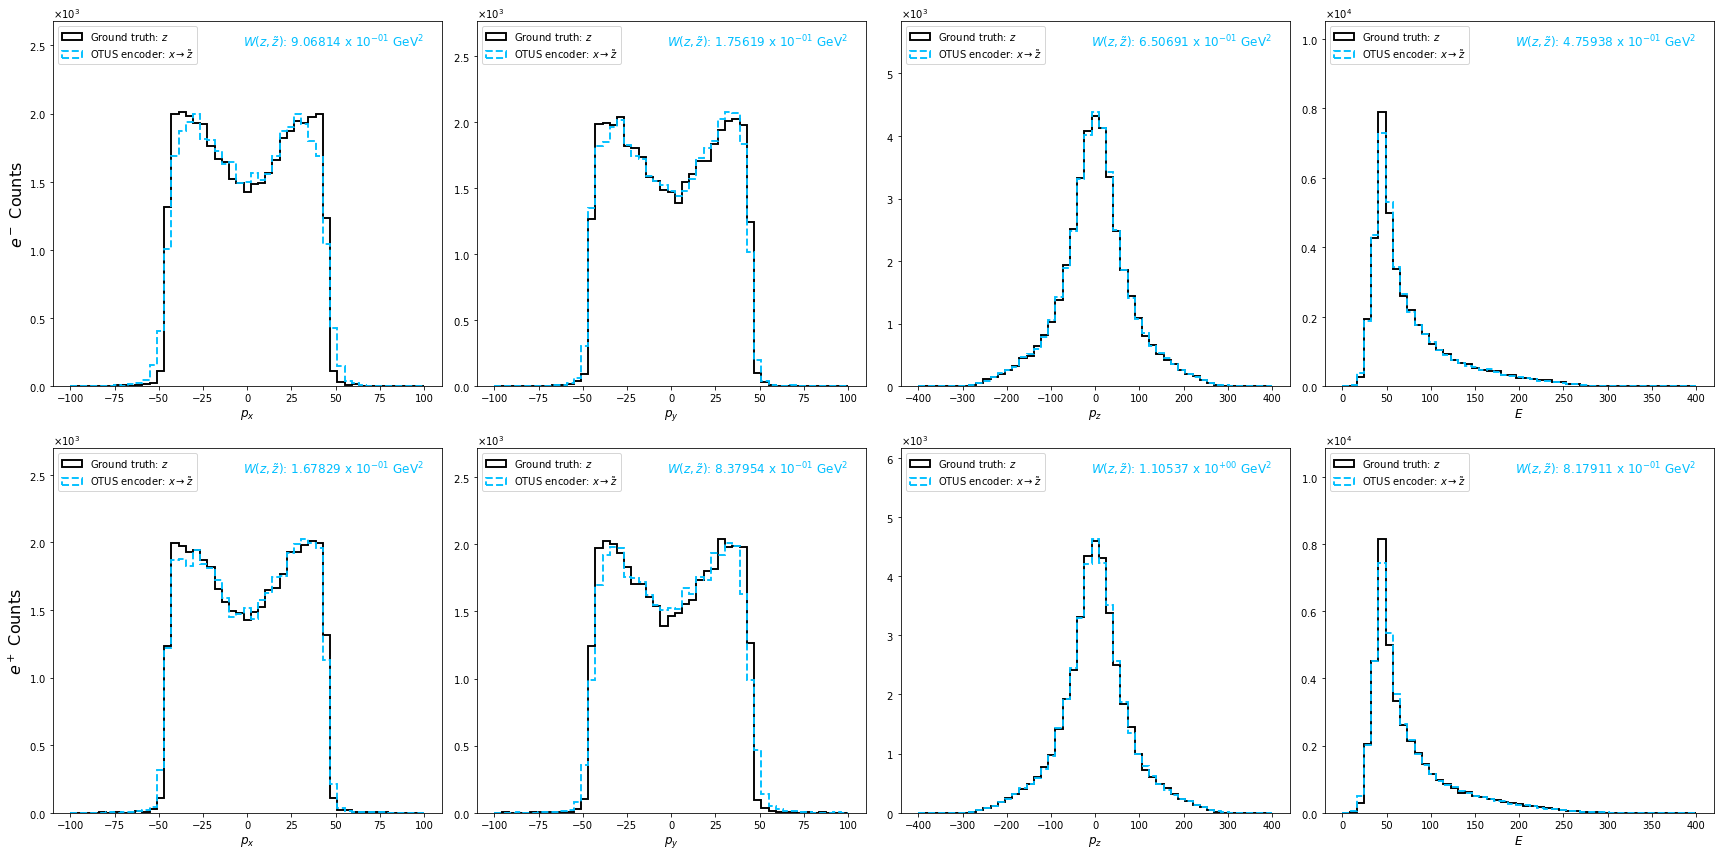

In [19]:
# Set plotting parameters
dataList = [arrs['z'], arrs['x_encoded']]
pltDim   = (2,4)
numBins  = 50
binsList = [np.linspace(-100.,100., numBins), 
            np.linspace(-100.,100., numBins), 
            np.linspace(-400.,400., numBins), 
            np.linspace(0.,400., numBins),
            np.linspace(-100.,100., numBins), 
            np.linspace(-100.,100., numBins), 
            np.linspace(-400.,400., numBins), 
            np.linspace(0.,400., numBins)]
particleNameList = [r'$e^-$', r'$e^+$']

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList = binsList, particleNameList = particleNameList)

### x-space 

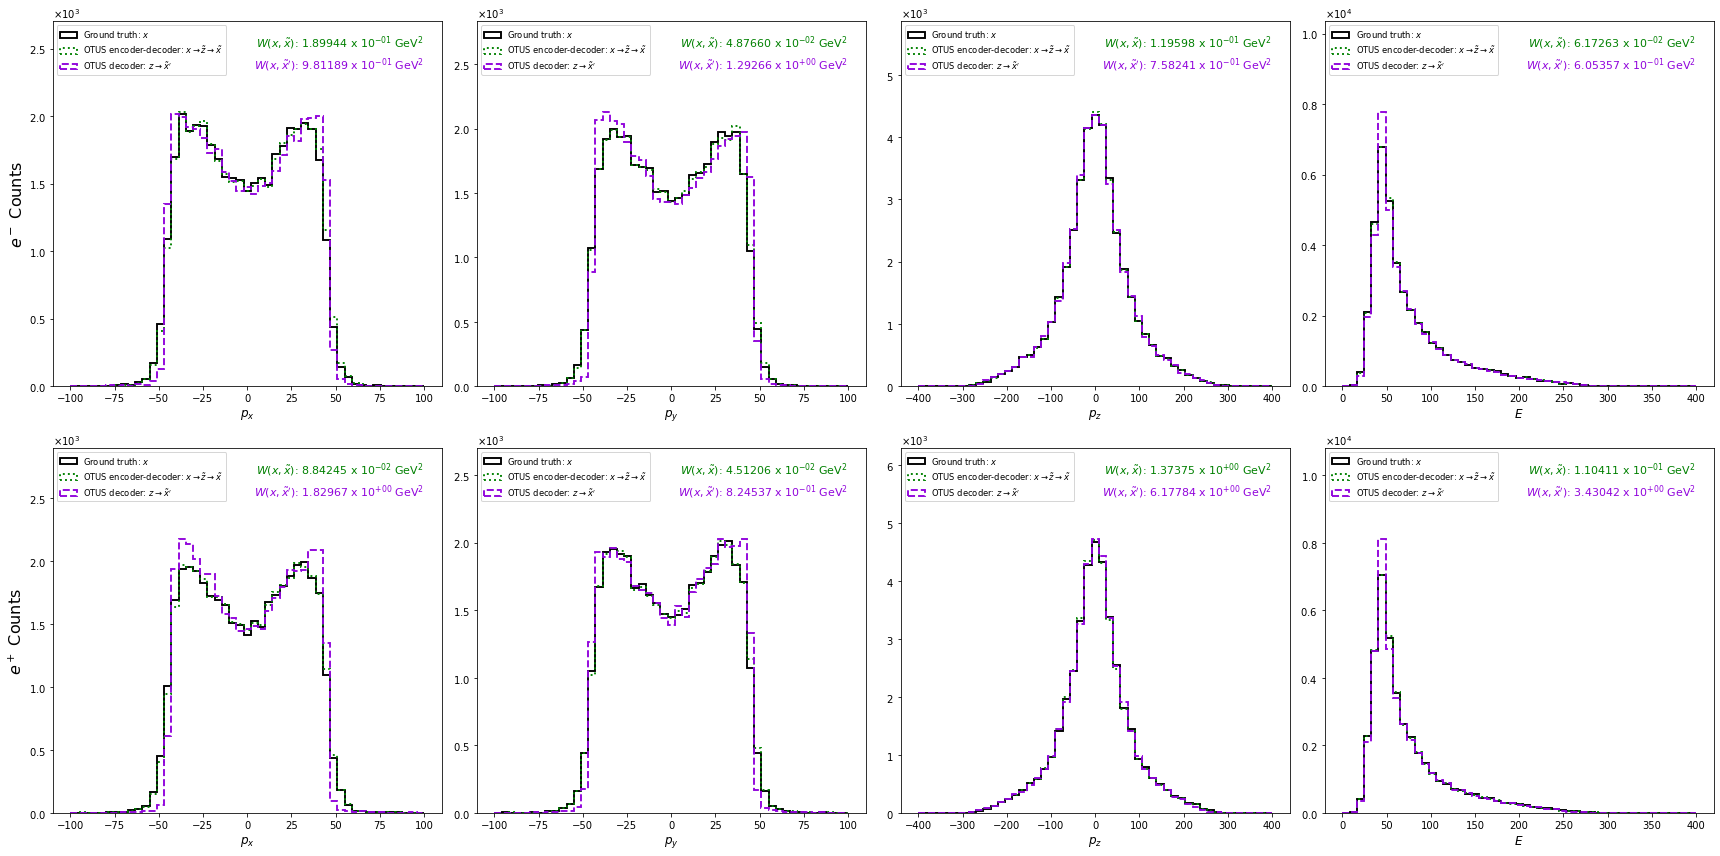

In [20]:
# Set plotting parameters
dataList = [arrs['x'], arrs['x_reconstructed'], arrs['z_decoded']]
pltDim   = (2,4)
numBins  = 50
binsList = [np.linspace(-100.,100., numBins), 
            np.linspace(-100.,100., numBins), 
            np.linspace(-400.,400., numBins), 
            np.linspace(0.,400., numBins),
            np.linspace(-100.,100., numBins), 
            np.linspace(-100.,100., numBins), 
            np.linspace(-400.,400., numBins), 
            np.linspace(0.,400., numBins)]
particleNameList = [r'$e^-$', r'$e^+$']

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList = binsList, particleNameList = particleNameList)

## Inspect Random Axes Matching On Validation Data

In [21]:
from func_utils import generateTheta

### z-space

In [22]:
# Calculate randomly projected data
true_samples = arrs['z']
num_projs = true_samples.shape[-1]

theta = generateTheta(num_projs, true_samples.shape[-1])  # np array
thetaT = theta.T
z_proj = arrs['z'] @ thetaT
x_encoded_proj = arrs['x_encoded'] @ thetaT

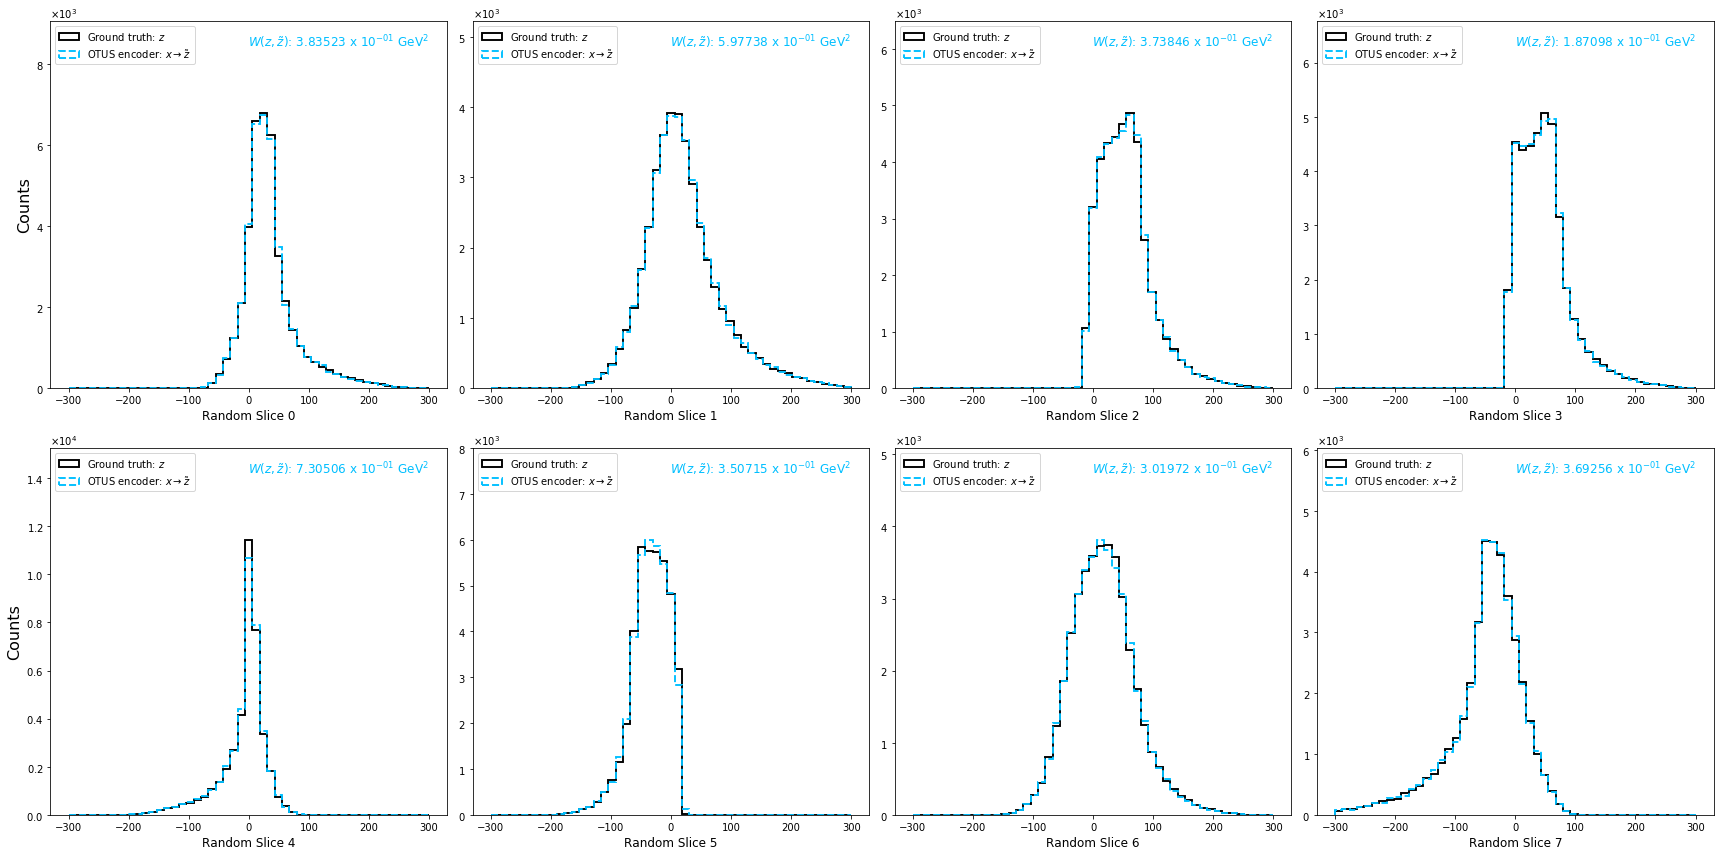

In [23]:
# Set plotting parameters
dataList = [z_proj, x_encoded_proj]

ncols = 4
assert num_projs % ncols == 0 # Make sure that numer of random projections will nicely accomodate 4 columns
nrows = num_projs // ncols
pltDim   = (nrows,ncols)

numBins  = 50
binsList = []
for i in range(num_projs):
    binsList.append(np.linspace(-300.,300., numBins)) 
particleNameList = []

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList = binsList, particleNameList = particleNameList)

### x-space 

In [24]:
# Calculate randomly projected data
true_samples = arrs['x']
num_projs = true_samples.shape[-1]

theta = generateTheta(num_projs, true_samples.shape[-1])  # np array
thetaT = theta.T
x_proj = arrs['x'] @ thetaT
z_decoded_proj = arrs['z_decoded'] @ thetaT
x_rec_proj = arrs['x_reconstructed'] @ thetaT

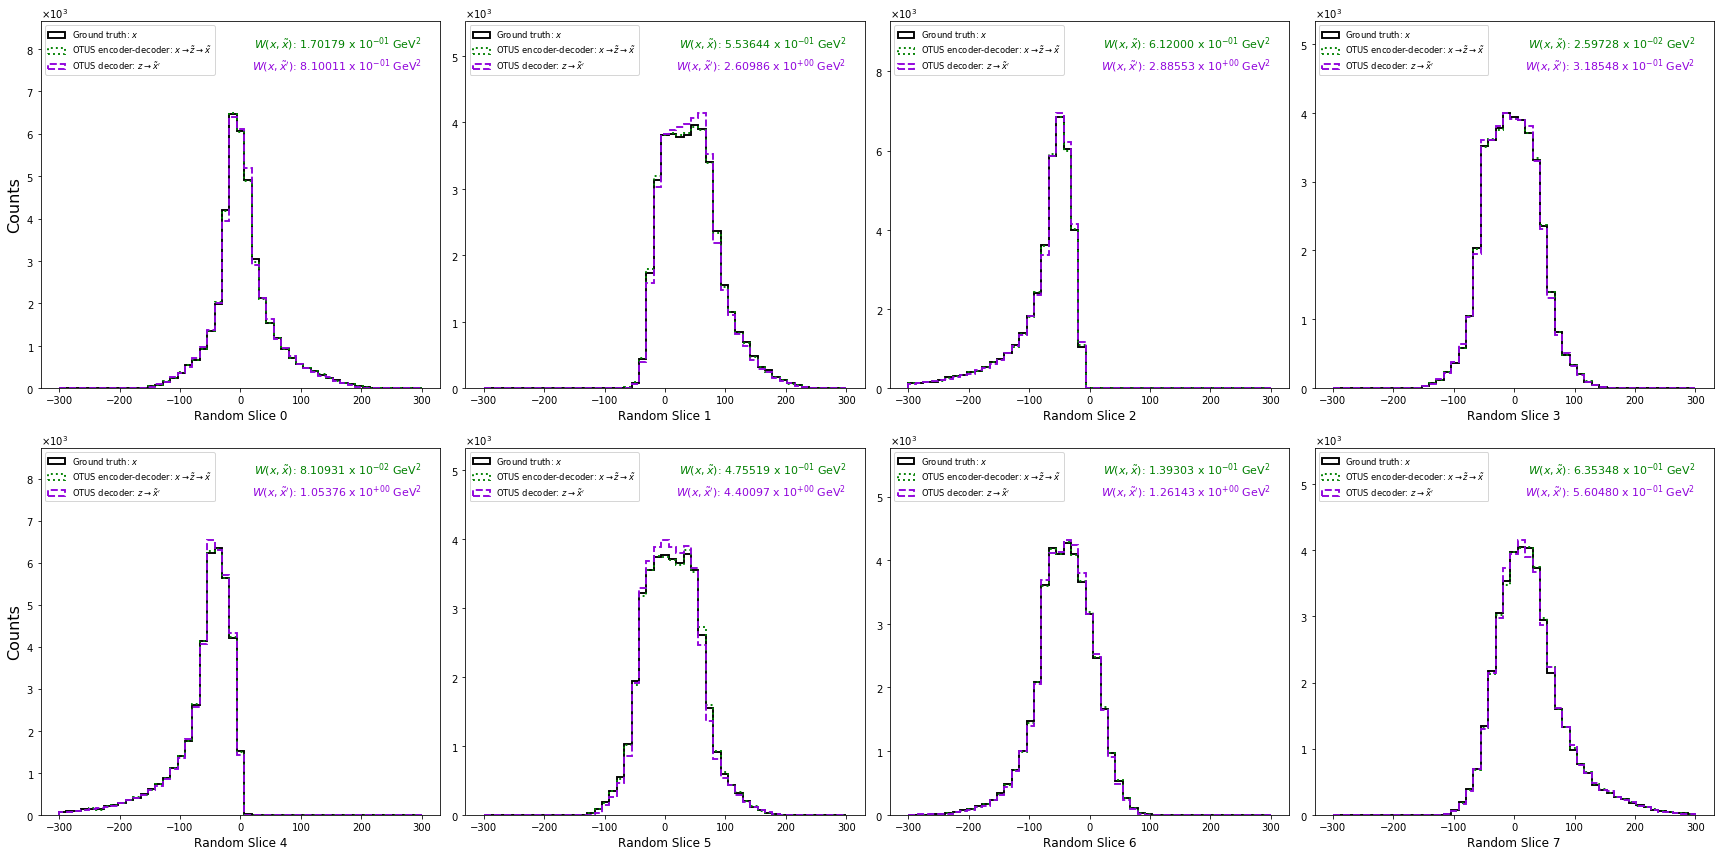

In [25]:
# Set plotting parameters
dataList = [x_proj, x_rec_proj, z_decoded_proj]

ncols = 4
assert num_projs % ncols == 0 # Make sure that numer of random projections will nicely accomodate 4 columns
nrows = num_projs // ncols
pltDim   = (nrows,ncols)

numBins  = 50
for i in range(num_projs):
    binsList.append(np.linspace(-300.,300., numBins))
particleNameList = []

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList = binsList, particleNameList = particleNameList)

## Inspect Derived Quantity Matching On Validation Data

Here we test the distribution matching on the derived quantitiy of the $Z$ boson mass.

In [26]:
from func_utils import Zboson_mass

In [27]:
data_key = 'val'
arrs = all_arrs[data_key]

### z-space

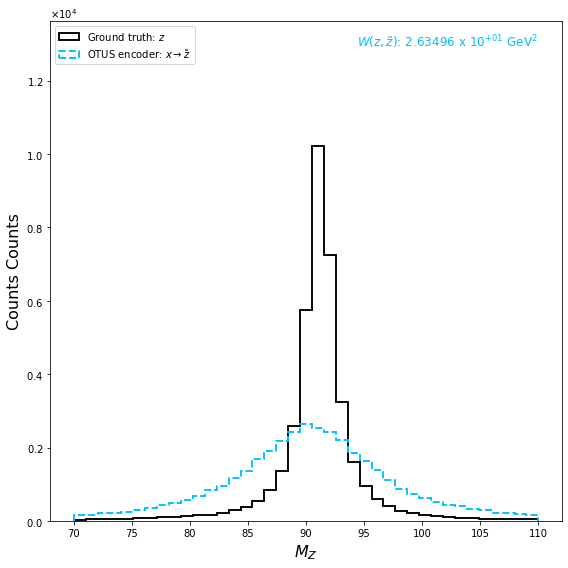

In [28]:
# Set plotting parameters
dataList = [Zboson_mass(arrs['z']), Zboson_mass(arrs['x_encoded'])]
pltDim   = (1,1)
numBins  = 40
binsList = [np.linspace(70.,110., numBins)]
particleNameList = []
nameList = [r'$M_Z$', r'Counts']

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList=binsList, particleNameList=particleNameList, nameList=nameList)

### x-space 

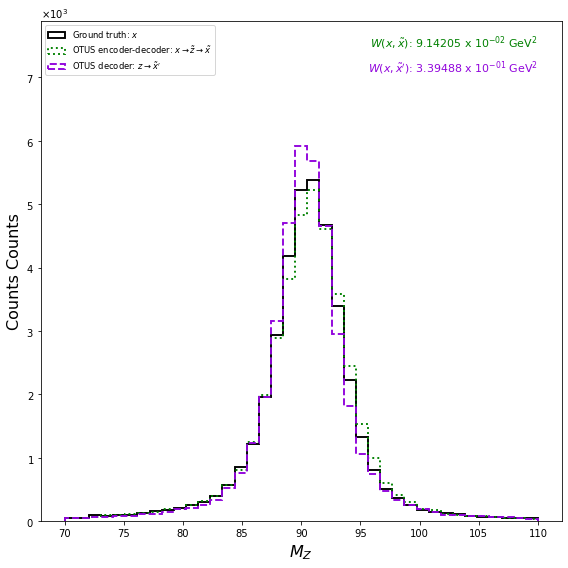

In [29]:
# Set plotting parameters
dataList = [Zboson_mass(arrs['x']), Zboson_mass(arrs['x_reconstructed']), Zboson_mass(arrs['z_decoded'])] 
pltDim   = (1,1)
numBins  = 40
binsList = [np.linspace(70.,110., numBins)]
particleNameList = []
nameList = [r'$M_Z$', r'Counts']

# Create plot
plotFunction(dataList = dataList, pltDim = pltDim, binsList=binsList, particleNameList=particleNameList, nameList=nameList)

## Inspect the relation between momenta of the $e^-$ and $e^+$ through the mappings

We plot the distribution of cosine distance between the unit-momentum before and after mapping.

We do this for the $e^-$ and $e^+$ for the encoder mapping: $x$ -> $\tilde{z}$

We do this for the $e^-$ and $e^+$ for the decoder mapping: $z$ -> $\tilde{x}^\prime$

In [30]:
from func_utils import cosine_sim

In [31]:
data_key = 'val'
arrs = all_arrs[data_key]

### Encoder

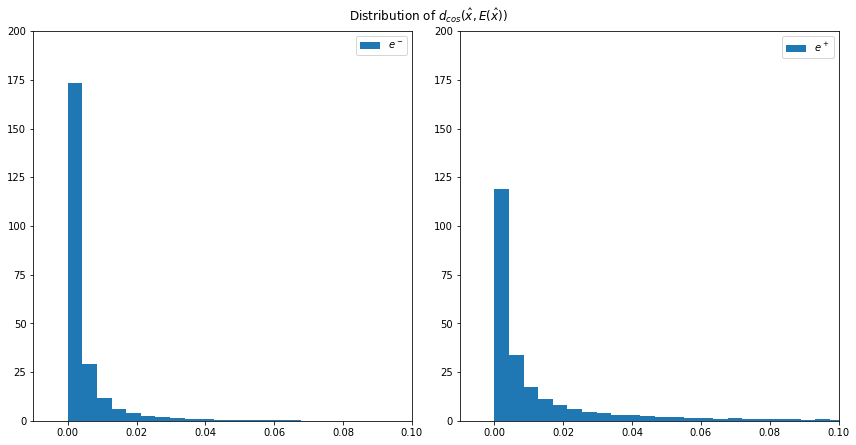

In [32]:
# Set plotting parameters
dataList = [1 - cosine_sim(arrs['x'][:, :4], arrs['x_encoded'][:, :4]), 
            1 - cosine_sim(arrs['x'][:, 4:], arrs['x_encoded'][:, 4:])]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
xlim = [-0.01, 0.1]
ylim = [0, 200]
particleNameList = [r'$e^-$', r'$e^+$']
bins = 100

# Plot histograms
for i in range(2):
    ax = axs[i]
    
    _, b, _ = ax.hist(dataList[i], bins=bins, label=particleNameList[i], density=True)
    bins = b
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig.suptitle(r'Distribution of $d_{cos}(\hat{x}, E(\hat{x}))$', va = 'bottom')
fig.tight_layout()
plt.show()


### Decoder

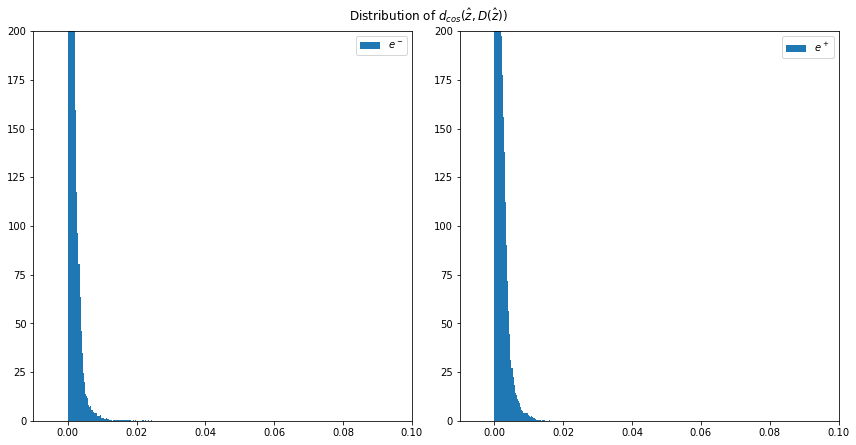

In [33]:
# Set plotting parameters
dataList = [1 - cosine_sim(arrs['z'][:, :4], arrs['z_decoded'][:, :4]), 
            1 - cosine_sim(arrs['z'][:, 4:], arrs['z_decoded'][:, 4:])]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
xlim = [-0.01, 0.1]
ylim = [0, 200]
particleNameList = [r'$e^-$', r'$e^+$']
bins = 100

# Plot histograms
for i in range(2):
    ax = axs[i]
    
    _, b, _ = ax.hist(dataList[i], bins=bins, label=particleNameList[i], density=True)
    bins = b
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig.suptitle(r'Distribution of $d_{cos}(\hat{z}, D(\hat{z}))$', va = 'bottom')
fig.tight_layout()
plt.show()

## Inspect 2D Qualities of the Results on Validation Data

In [34]:
from plot_utils import compare_hist2d

In [35]:
data_key = 'val'
arrs = all_arrs[data_key]

### z-data

#### Compare electron's $p_x$ vs $p_y$ in 2D plot

x range: -247.81465 140.12462
y range: -119.78438 136.53381
x range: -254.58017 165.99261
y range: -126.03639 146.04147


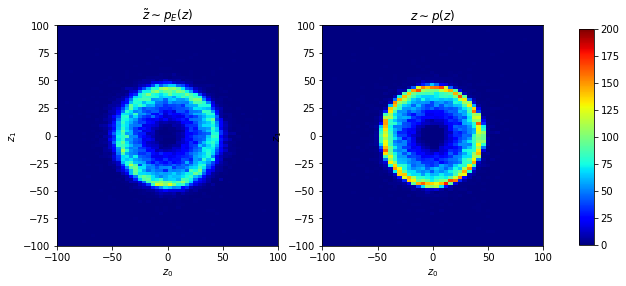

In [36]:
# Set plot parameters
dataList   = [arrs['x_encoded'], arrs['z']]
coords     = np.array([0, 1]) # 0 for px, 1 for py of the electron
titles     = [r'$ \tilde{z} \sim p_E(z)$', r'$z \sim p(z)$'] 
nbins      = 100
vmin, vmax = 0, 200 # cmap range
cmap       = 'jet'
xlim       = [-100, 100]
ylim       = [-100, 100]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

#### Compare electron's $p_y$ vs $p_z$ in 2D plot

x range: -119.78438 136.53381
y range: -458.9364 357.20865
x range: -126.03639 146.04147
y range: -498.1236 370.2469


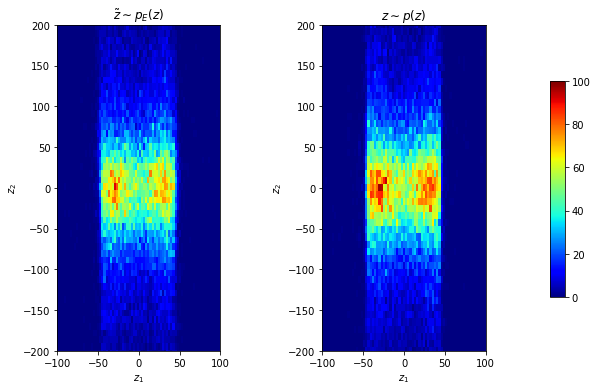

In [37]:
# Set plot parameters
dataList   = [arrs['x_encoded'], arrs['z']]
coords     = np.array([1, 2]) # 1 for py, 2 for pz of the electron
titles     = [r'$ \tilde{z} \sim p_E(z)$', r'$z \sim p(z)$'] 
nbins      = 100
vmin, vmax = 0, 100 # cmap range
cmap       = 'jet'
xlim       = [-100, 100]
ylim       = [-200, 200]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

#### Compare electron's $p_z$ vs $E$ in 2D plot

x range: -458.9364 357.20865
y range: 11.812587 468.9629
x range: -498.1236 370.2469
y range: 10.826708 507.99615


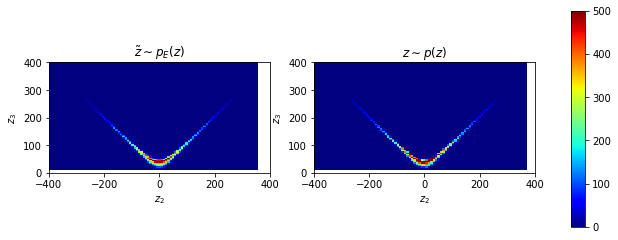

In [38]:
# Set plot parameters
dataList   = [arrs['x_encoded'], arrs['z']]
coords     = np.array([2, 3]) # 2 for pz, 3 for E of the electron
titles     = [r'$ \tilde{z} \sim p_E(z)$', r'$z \sim p(z)$'] 
nbins      = 100
vmin, vmax = 0, 500 # cmap range
cmap       = 'jet'
xlim       = [-400, 400]
ylim       = [0, 400]

# Create plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

### x-data

#### Compare electron's $p_x$ vs $p_y$ in 2D plot

x range: -302.9154 178.91031
y range: -144.79723 162.80905
x range: -262.80835 150.86113
y range: -132.7116 144.0342


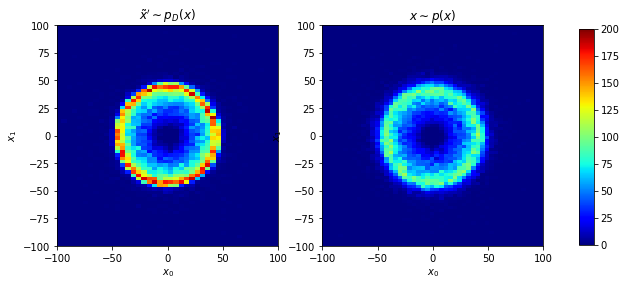

In [39]:
# Set plot parameters
dataList   = [arrs['z_decoded'], arrs['x']]
coords     = np.array([0, 1]) # 0 for px, 1 for py of the electron
titles     = [r'$ \tilde{x}^\prime \sim p_D(x)$', r'$x \sim p(x)$'] 
nbins      = 100
vmin, vmax = 0, 200 # cmap range
cmap       = 'jet'
xlim       = [-100, 100]
ylim       = [-100, 100]

# Make plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

#### Compare electron's $p_y$ vs $p_z$ in 2D plot

x range: -144.79723 162.80905
y range: -487.69424 379.28452
x range: -132.7116 144.0342
y range: -464.69226 367.5784


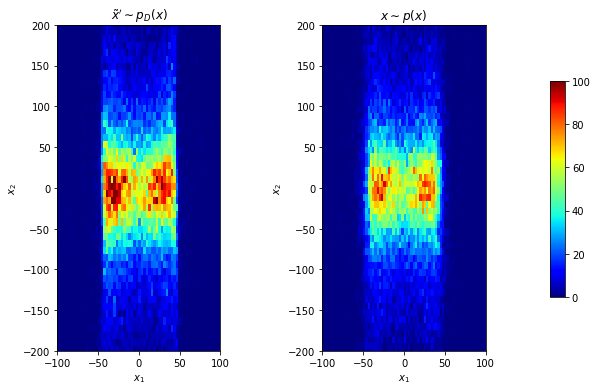

In [40]:
# Set plot parameters
dataList   = [arrs['z_decoded'], arrs['x']]
coords     = np.array([1, 2]) # 1 for py, 2 for pz of the electron
titles     = [r'$ \tilde{x}^\prime \sim p_D(x)$', r'$x \sim p(x)$'] 
nbins      = 100
vmin, vmax = 0, 100 # cmap range
cmap       = 'jet'
xlim       = [-100, 100]
ylim       = [-200, 200]

# Make plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

#### Compare electron's $p_z$ vs $E$ in 2D plot

x range: -487.69424 379.28452
y range: 8.939922 496.53384
x range: -464.69226 367.5784
y range: 11.009572 474.74207


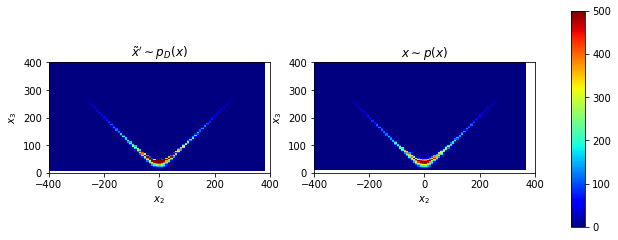

In [41]:
# Set plot parameters
dataList   = [arrs['z_decoded'], arrs['x']]
coords     = np.array([2, 3]) # 2 for pz, 3 for E of the electron
titles     = [r'$ \tilde{x}^\prime \sim p_D(x)$', r'$x \sim p(x)$'] 
nbins      = 100
vmin, vmax = 0, 500 # cmap range
cmap       = 'jet'
xlim       = [-400, 400]
ylim       = [0, 400]

# Make plot
compare_hist2d(dataList, coords=coords, titles=titles, bins=nbins, vmin=vmin, vmax=vmax, cmap=cmap, xlim=xlim, ylim=ylim)

## Inspect Mappings with Transport Plots on Validation Data

Note that transport plots take a while to render.

In [42]:
from plot_utils import fullTransportPlot 

In [43]:
data_key = 'val'
arrs = all_arrs[data_key]

### Decoder mappings

In [44]:
nzList    = [20,20,20,20,20,20,20,20]
nxList    = [20,20,20,20,20,20,20,20]
x_display_lims = [(-100, 100), (-100, 100), (-400, 400), (0, 400)]
limzList = x_display_lims * 2
limxList = x_display_lims * 2
pltDim    = (2,4)
titleList = [r'$p_x$',r'$p_y$',r'$p_z$',r'$E$','','','','']

#### Transport plans for $z$ -> $\tilde{x}^\prime$

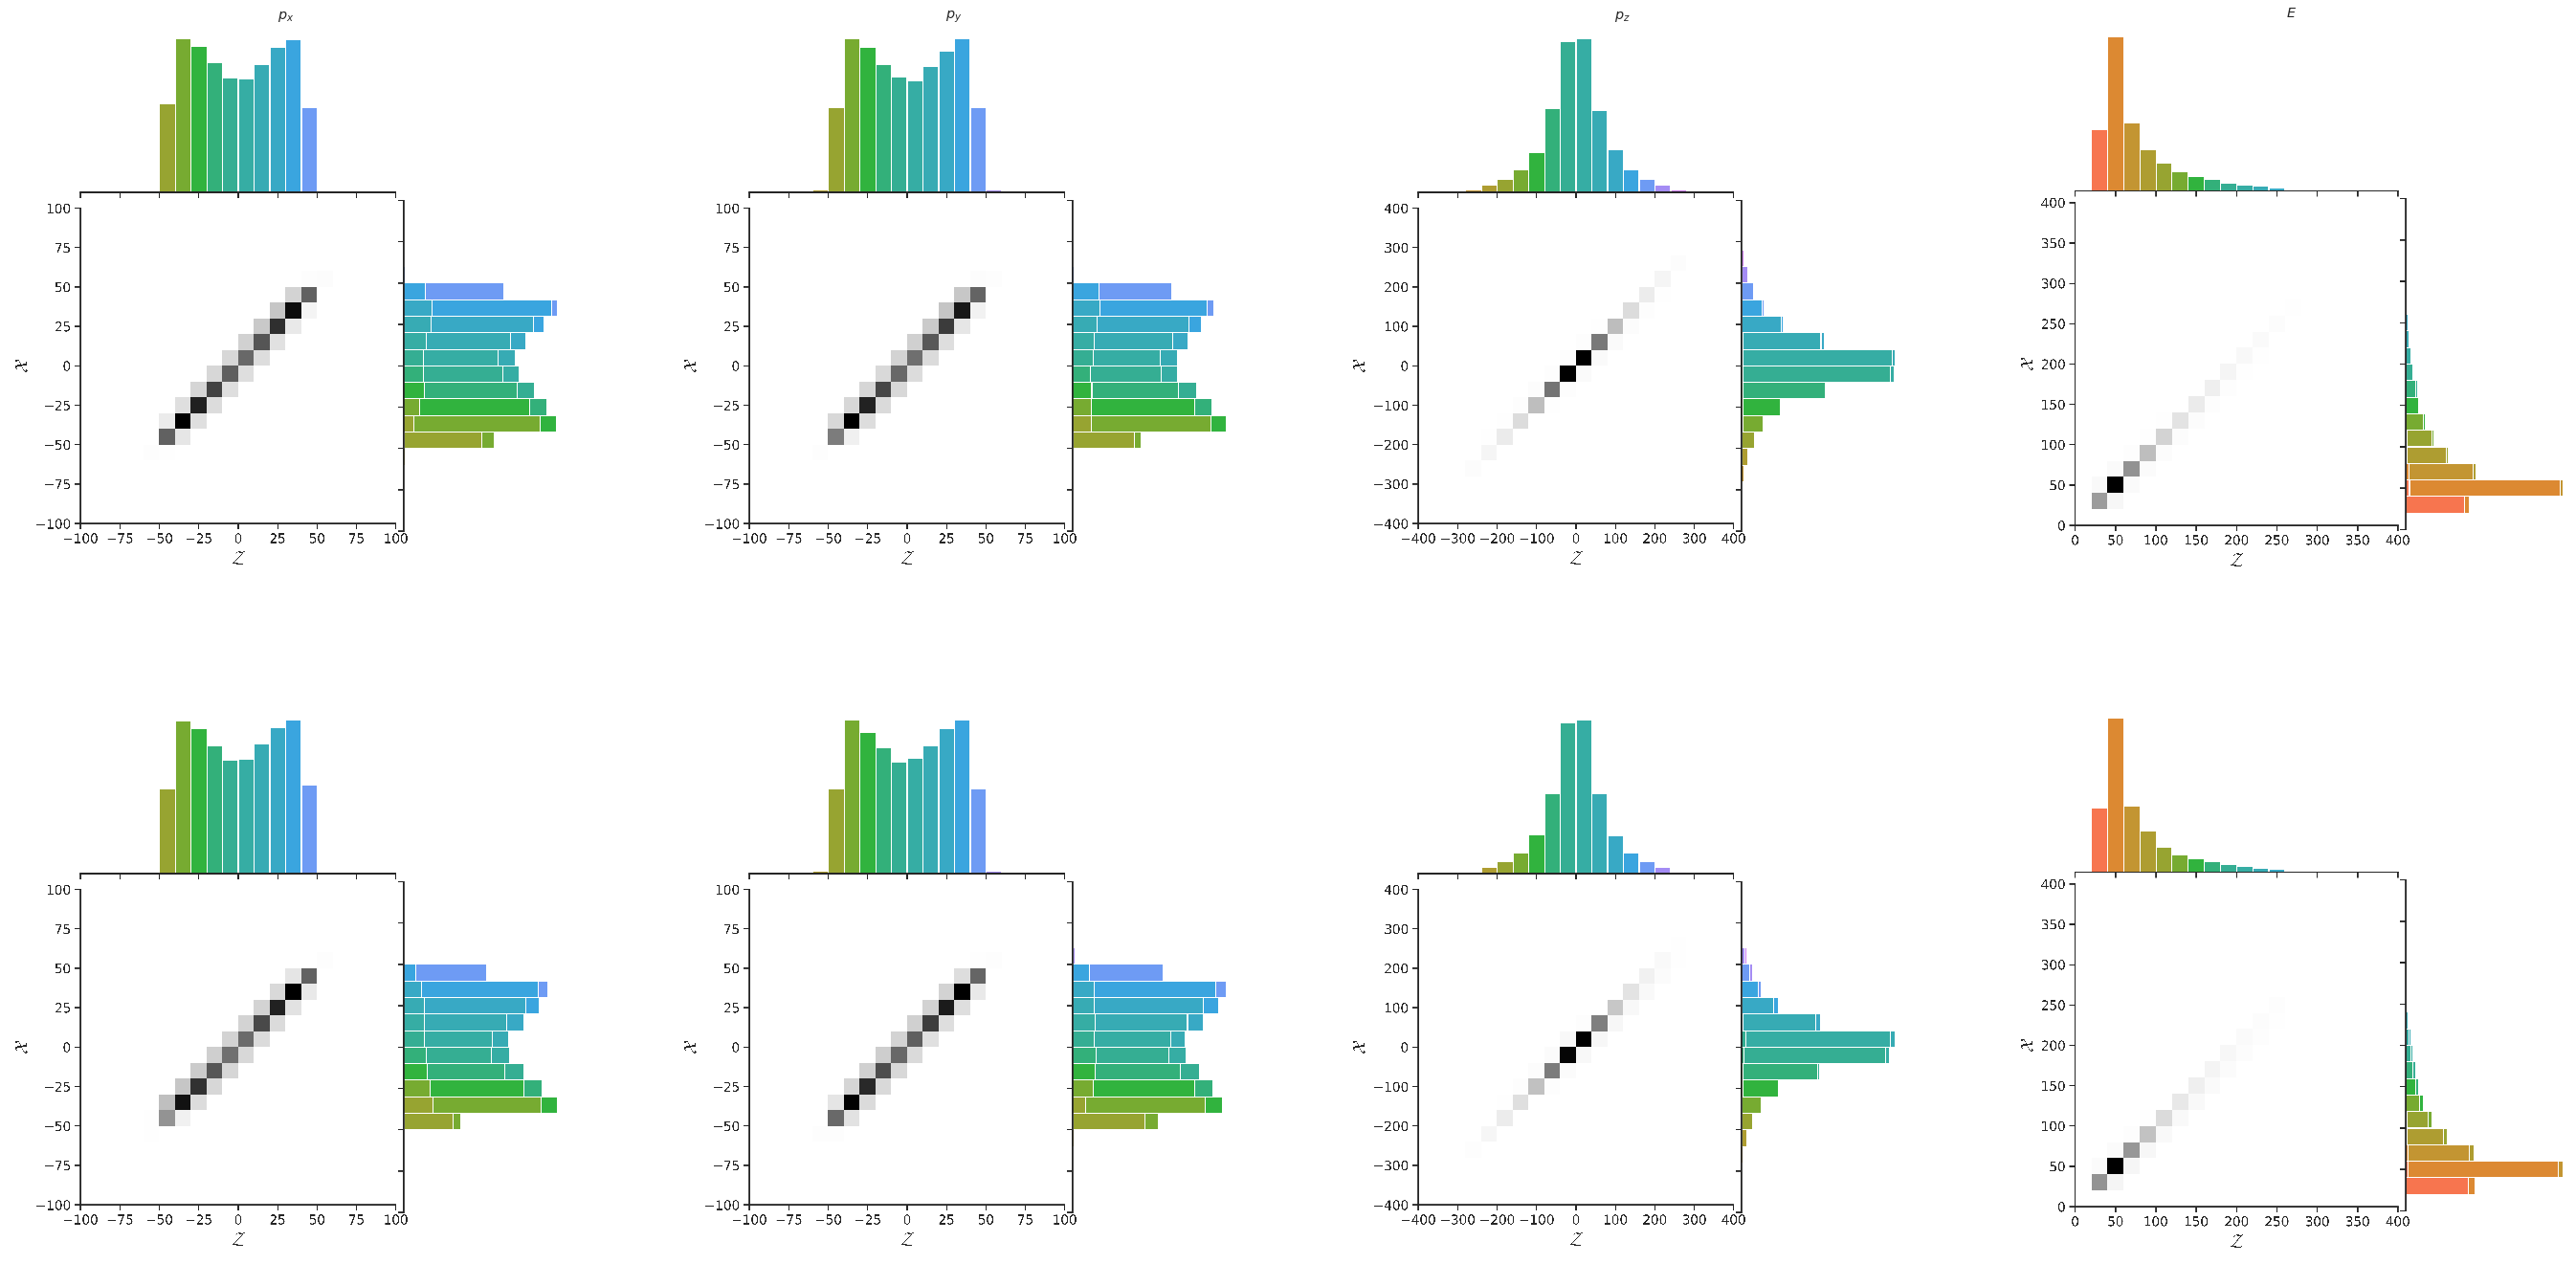

In [45]:
fullTransportPlot(arrs['z'], arrs['z_decoded'][:, 0:8], nzList=nzList, nxList=nxList, limzList=limzList, limxList=limxList, pltDim=pltDim, titleList=titleList)

#### Transport plans for $\tilde{z}$ -> $\tilde{x}$

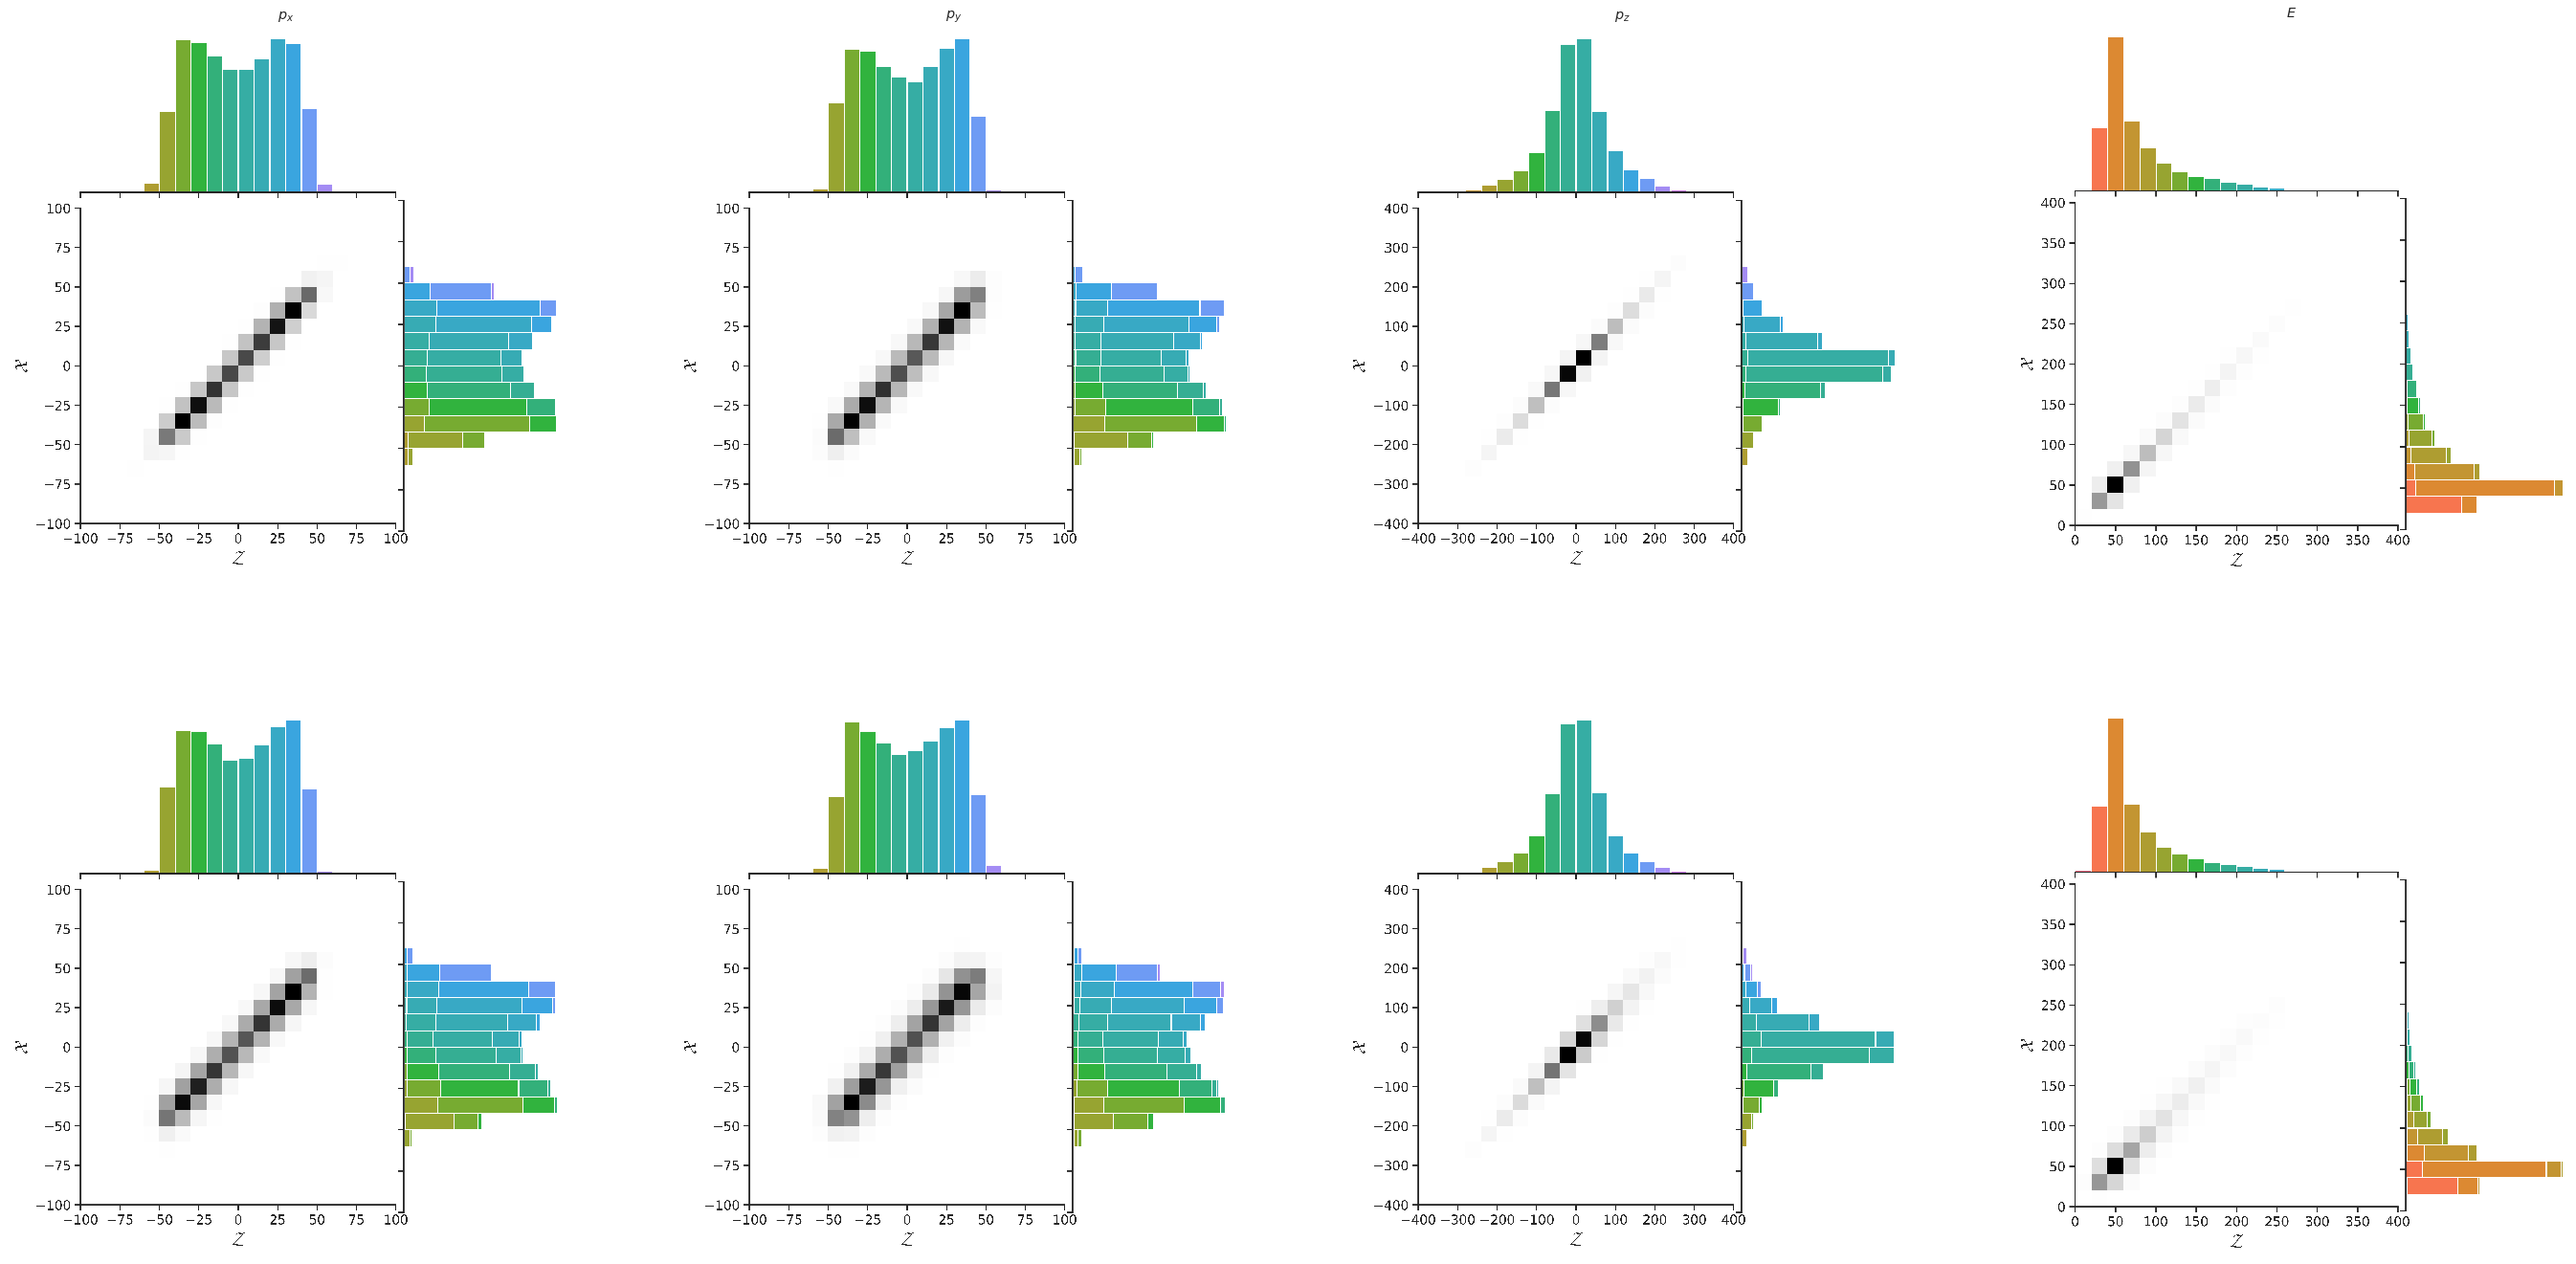

In [46]:
fullTransportPlot(arrs['x_encoded'], arrs['x_reconstructed'][:, 0:8], nzList=nzList, nxList=nxList, limzList=limzList, limxList=limxList, pltDim=pltDim, titleList=titleList)

#### Transport plans for true mapping $z$ -> $x$ (Now on Training Data)

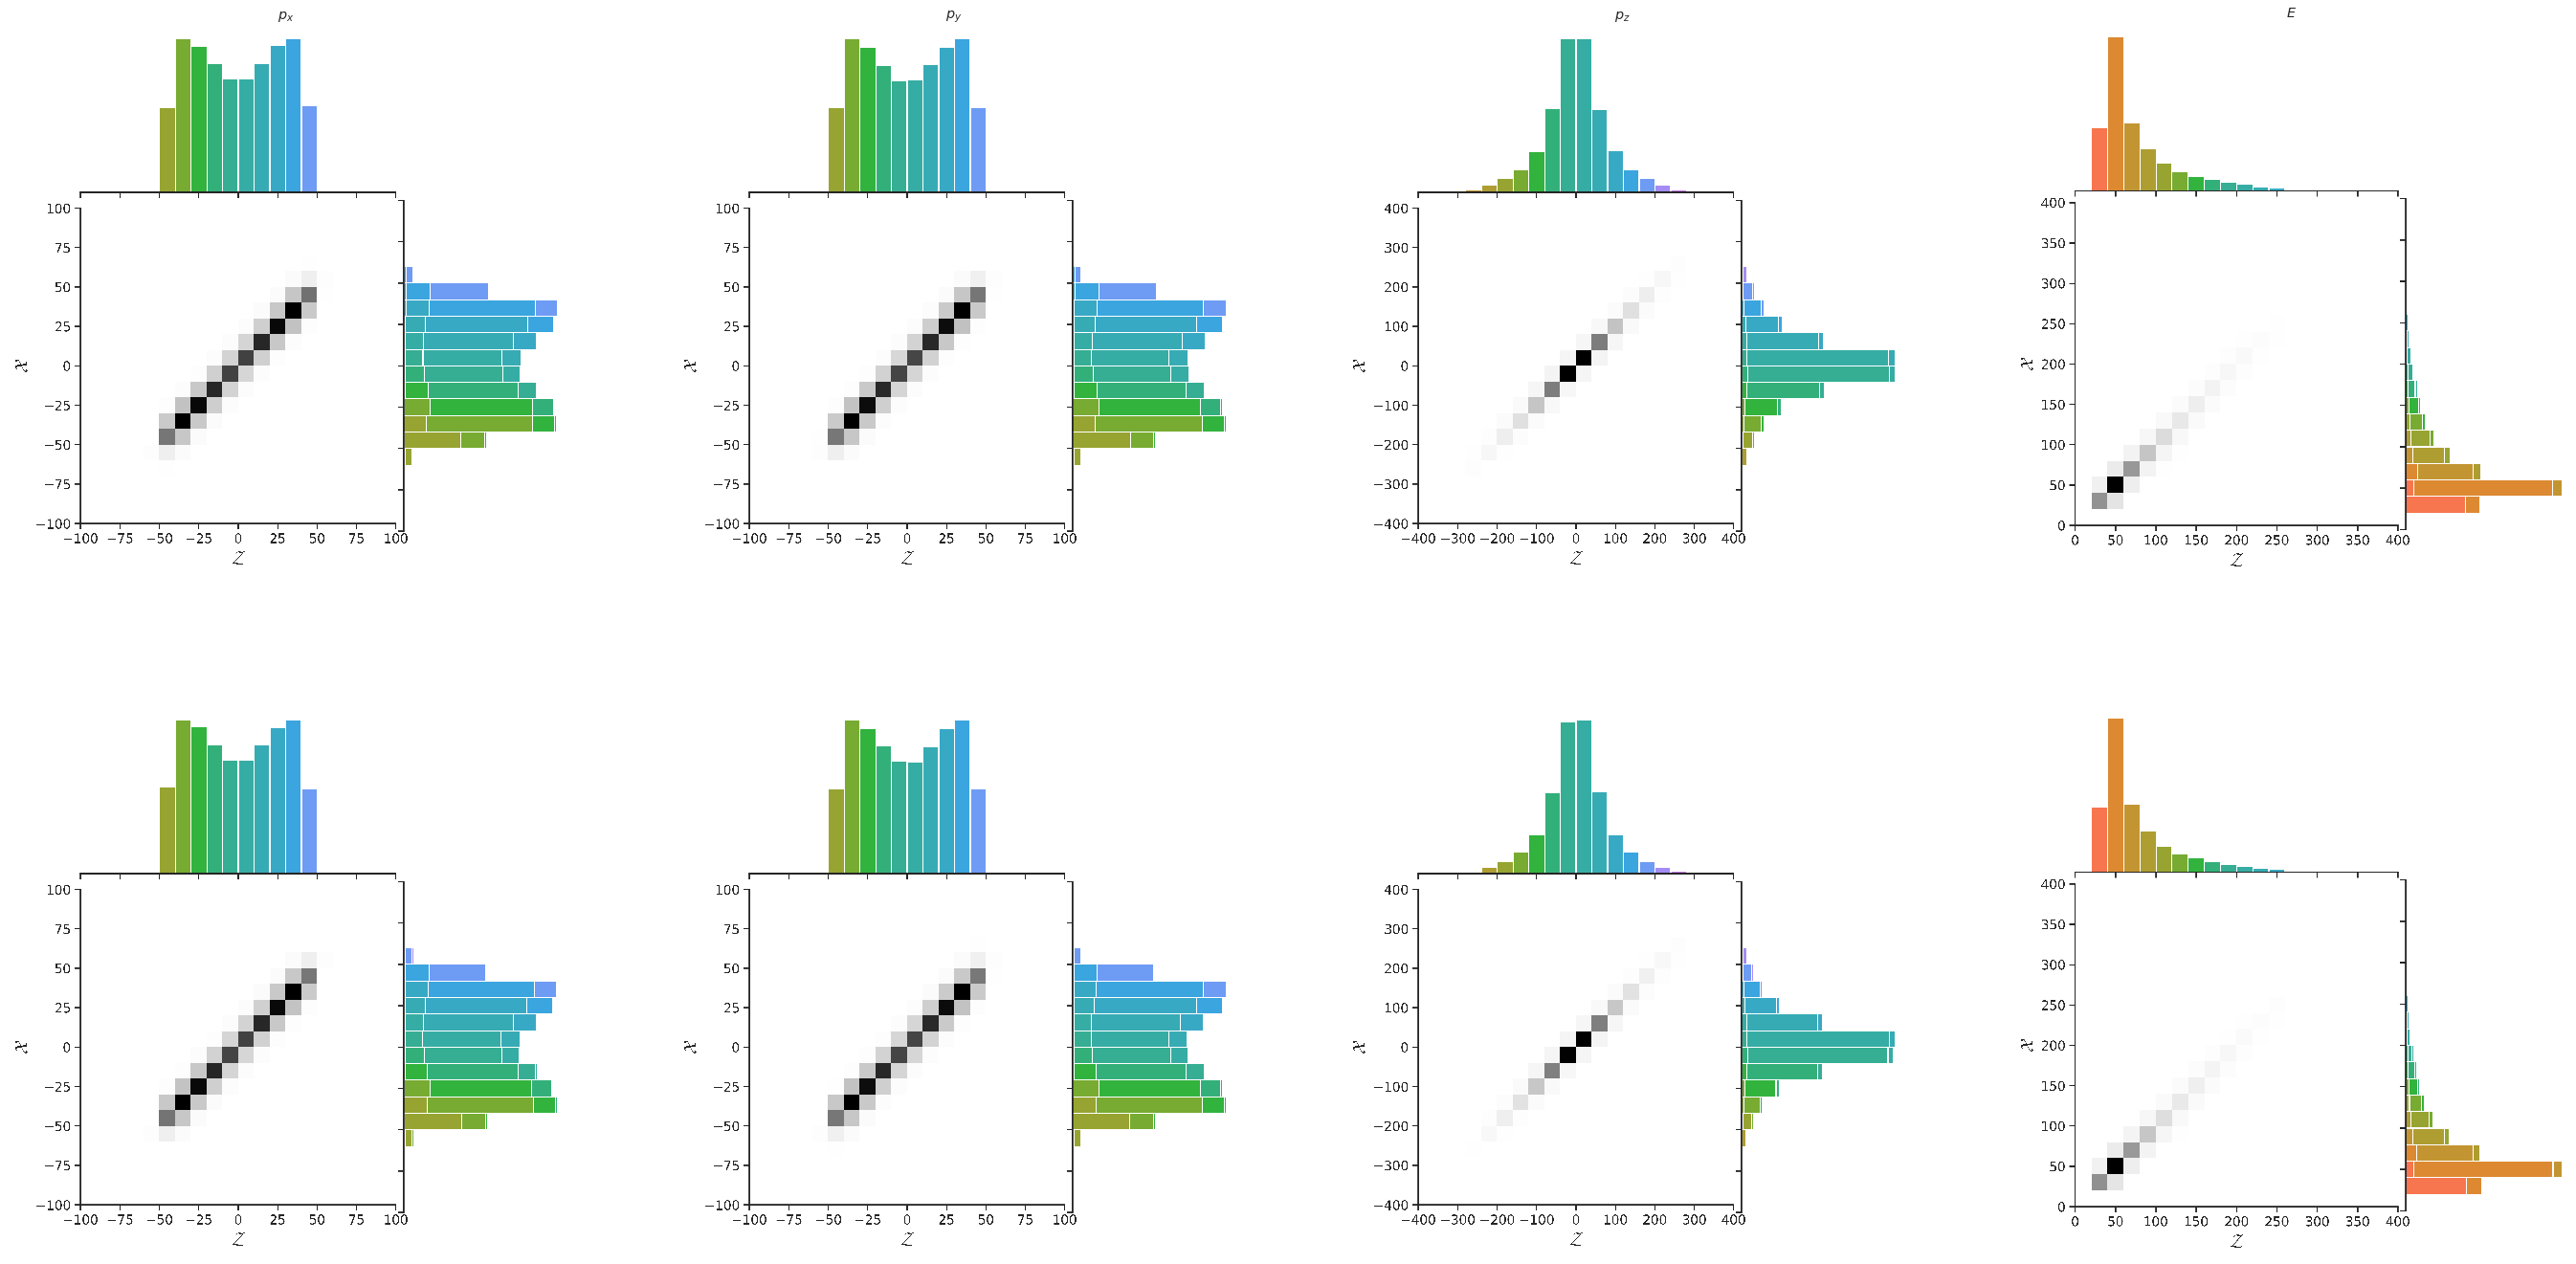

In [47]:
arrs = all_arrs['train']
fullTransportPlot(arrs['z'], arrs['x'][:, 0:8], nzList=nzList, nxList=nxList, limzList=limzList, limxList=limxList, pltDim=pltDim, titleList=titleList)

## Inspect Stochasticity of Decoder Mapping on Validation Data

In [48]:
from plot_utils import fullDiffPlot

In [49]:
data_key = 'val'
arrs = all_arrs[data_key]

In [50]:
x_display_lims = [(-100, 100), (-100, 100), (-400, 400), (0, 400)]
limzList = x_display_lims * 2
limxList = x_display_lims * 2
pltDim    = (2,4)
titleList = [r'$p_x$',r'$p_y$',r'$p_z$',r'$E$','','','','']

Fix $z$, study the transformation into $\tilde{x}^\prime$ many times to see the distribution. We plot the difference ($\tilde{x}^\prime - z$) as a function of the input z.

common_num_repeats 100


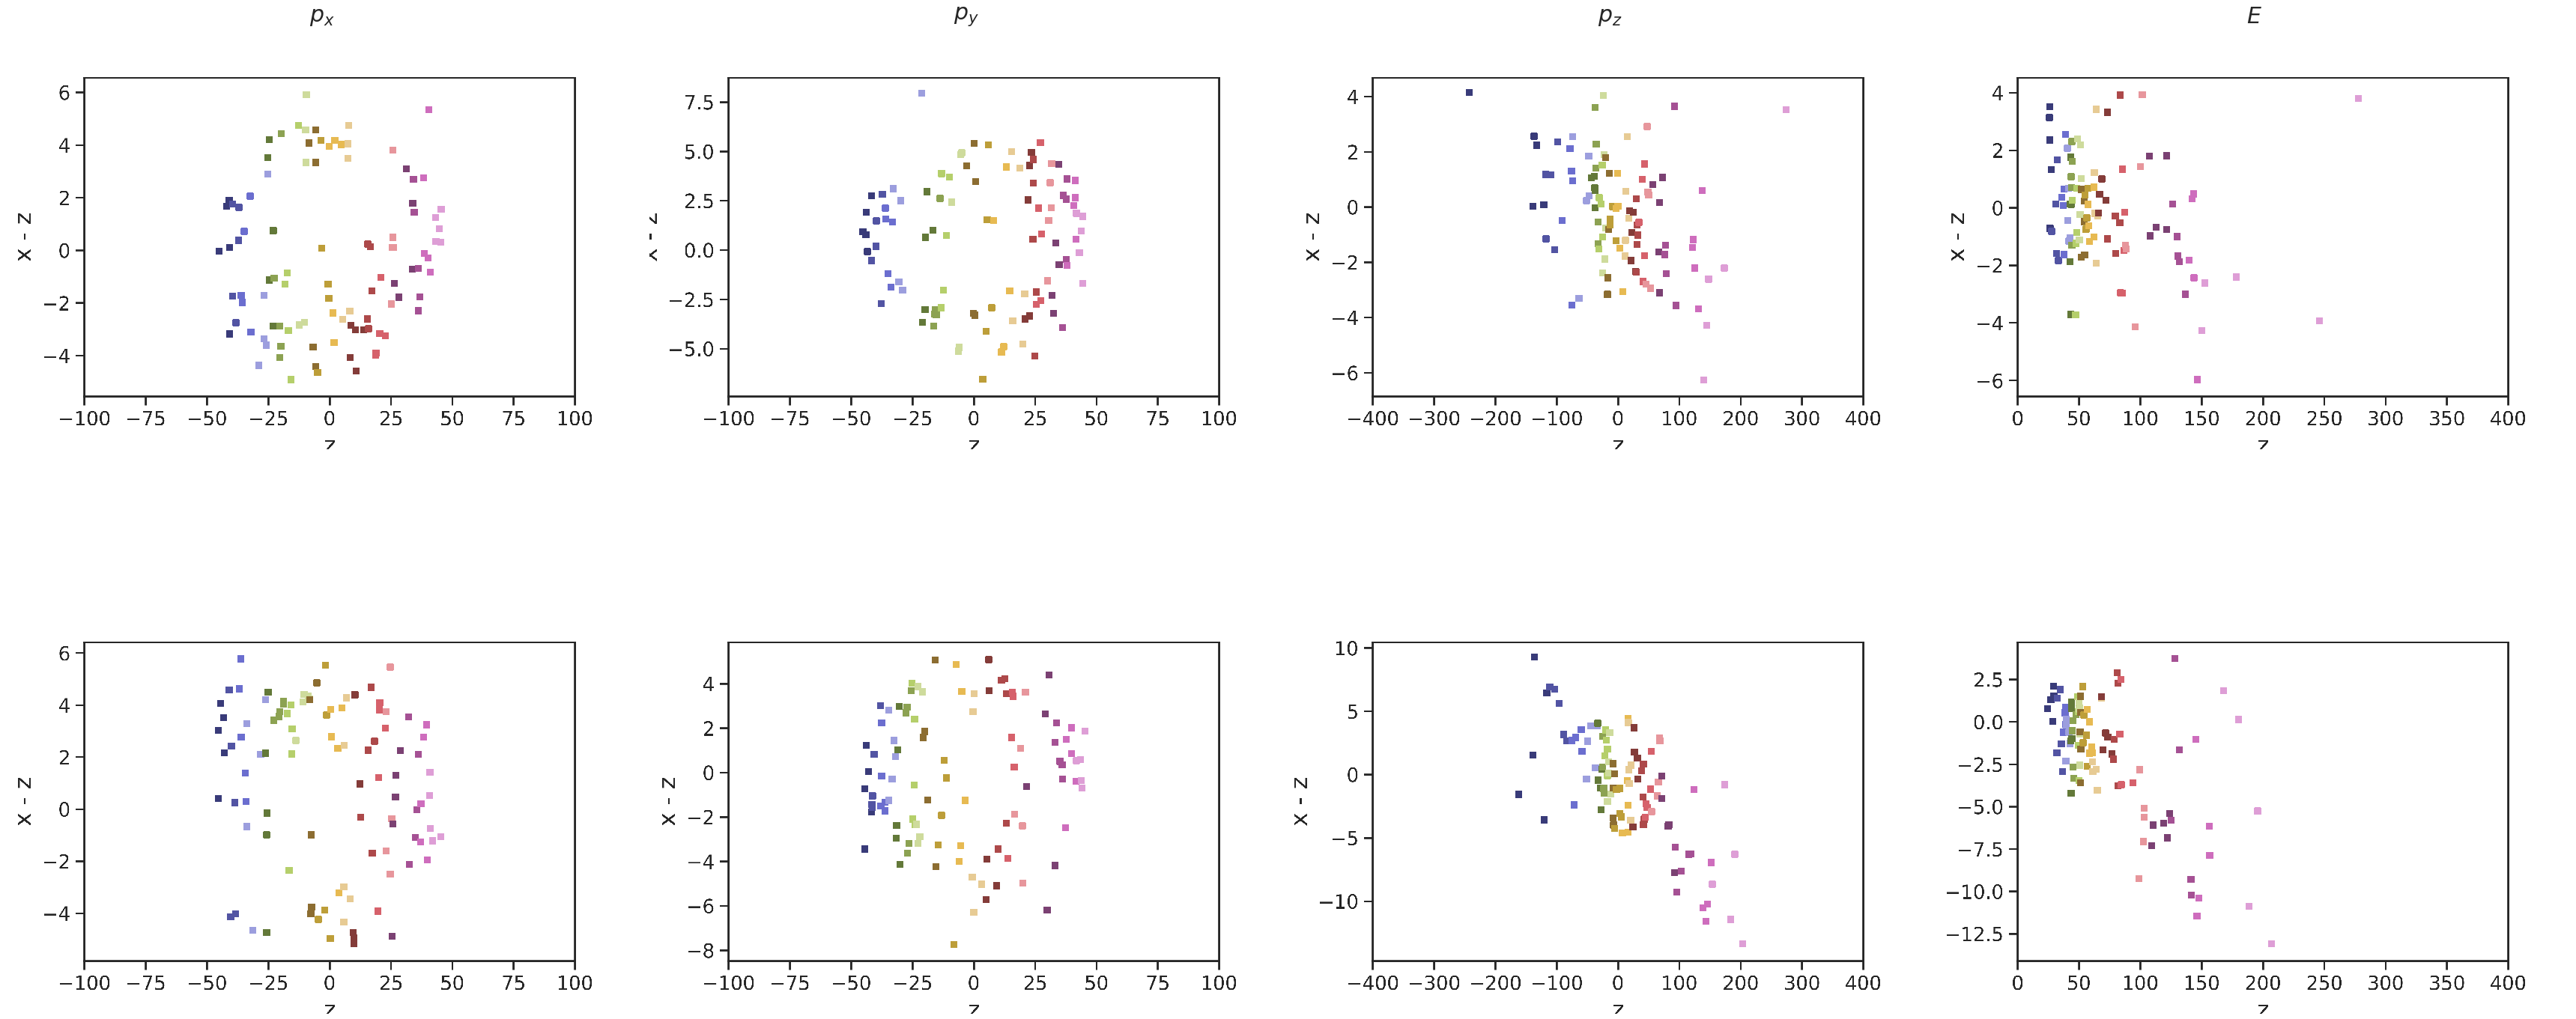

In [51]:
fullDiffPlot(arrs['z_rep'], arrs['z_decoded_rep'], limList=limzList, pltDim=pltDim, titleList=titleList, dec=True)

Then for these fixed $z$ samples, we look at their true corresponding $x$. Note that we do not have data which can easily tell us the distribution of true $x$ given a fixed $z$. We only have one such pair. 

This means that all repeats will be plotted on top of one another, whereas in the previous plot they were spread out. In these plots, each color corresponds to a different fixed $z$.

common_num_repeats 100


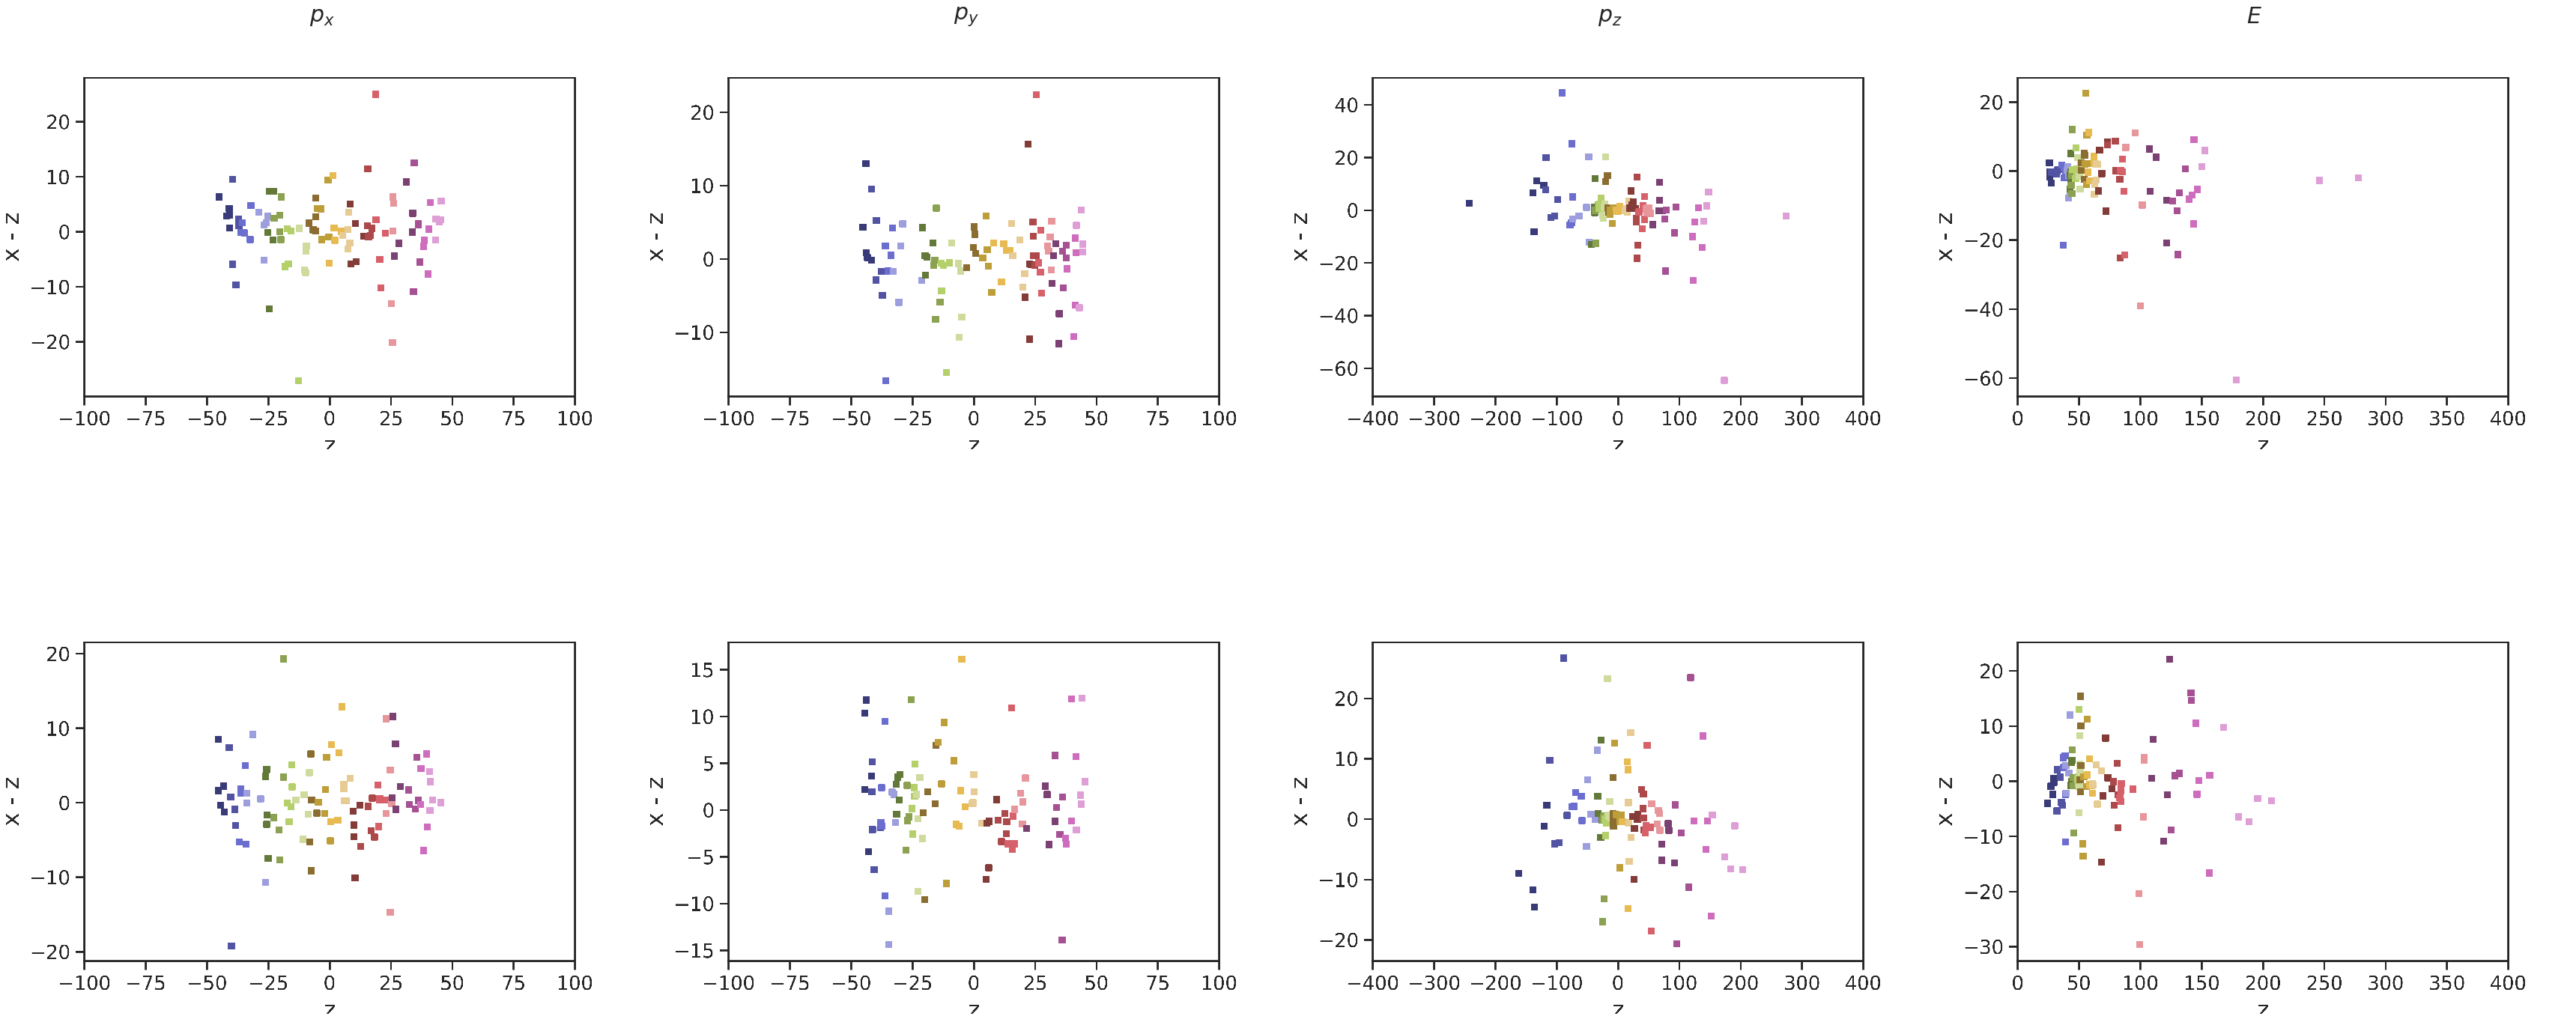

In [52]:
fullDiffPlot(arrs['z_rep'], arrs['x_rep'], limList=limzList, pltDim=pltDim, titleList=titleList, dec=True)

# Save Trained Model

In [53]:
save_path = 'otus-dataset=%s.pkl' %dataset_name
torch.save(model.state_dict(), save_path)
print('Saved model weights to', save_path)

Saved model weights to otus-dataset=ppzee.pkl


# Evaluate Trained Model on Testing Data

For easier downstream analysis we also evaluate the trained model on our testing dataset.

In [54]:
#-- Get testing dataset --#
test_dataset_name = 'ppzee_test'
test_dataset = get_dataset(test_dataset_name)
test_z_data, test_x_data = test_dataset['z_data'], test_dataset['x_data']

MET = False # Exclude Missing Transverse Energy (MET) from x-space data
if MET == False:
    test_x_data = test_x_data[:, :-4]
print(test_z_data.shape, test_x_data.shape)

(160000, 8) (160000, 8)


In [55]:
#-- Evaluate trained model on testing dataset --#

# Use CPU instead of GPU
model.to('cpu')
model.encoder.output_stats.to('cpu')
model.decoder.output_stats.to('cpu')

# Convert the whole testing dataset's type and add to all_arrs
all_arrs['test'] = {}
all_arrs['test']['x'] = np.array(test_x_data, dtype=float_type) 
all_arrs['test']['z'] = np.array(test_z_data, dtype=float_type) 
print(all_arrs['test']['x'].shape, all_arrs['test']['z'].shape)

# Evaluate trained model on testing dataset
arrs = all_arrs['test']

arrs['z_decoded'] = model.decode(torch.from_numpy(arrs['z'])) # p_D(x) = \int_z p(z) p_D(x|z)  "x_pred_truth"
arrs['x_encoded'] = model.encode(torch.from_numpy(arrs['x'])) # p_E(z) = \int_x p(x) p_E(z|x)  "z_pred"
arrs['x_reconstructed'] = model.decode(arrs['x_encoded'])     # p_D(y) = \int_x \int_z p(x) p_E(z|x) p_D(y|z) "x_pred"
       
# Feed the same z input to the decoder multiple times and study the stochastic output
num_repeats = 100
num_diff_zs = 100

arrs['z_rep'] = np.array([np.repeat(arrs['z'][i:i+1], num_repeats, axis=0) for i in range(num_diff_zs)])       # "z_fixed"
z_rep_tensor = torch.from_numpy(arrs['z_rep'])                                                                 # tmp
arrs['z_decoded_rep'] = np.array([model.decode(z_rep_tensor[i]).detach().numpy() for i in range(num_diff_zs)]) # "x_pred_truth_fixed"
arrs['x_rep'] = np.array([np.repeat(arrs['x'][i:i+1], num_repeats, axis=0) for i in range(num_diff_zs)])       # "x_fixed"

# Convert all results to numpy arrays
for (field, arr) in arrs.items():
    if isinstance(arr, torch.Tensor):
        arrs[field] = arr.detach().numpy()

(160000, 8) (160000, 8)


In [56]:
save_path = 'otus_results-dataset=%s.npz' %test_dataset_name
np.savez(save_path, **all_arrs['test'])
print('Model results saved at', save_path)

Model results saved at otus_results-dataset=ppzee_test.npz
